In [ ]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import glob
import itertools
from scipy.stats import norm
import matplotlib.colors as mcolors
from matplotlib import rcParams
import figure_formatting as ff
import yaml
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import textwrap
%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):


Load filepaths

In [2]:
with open("general_analysis_parameters.yaml", "r") as file:
    gen_parameters = yaml.safe_load(file)
rcParams['font.sans-serif'] = gen_parameters['font']
rcParams['font.family'] = gen_parameters['font']
rcParams['font.size'] = gen_parameters['font_size']
font_size = gen_parameters['font_size']

If you haven't done yet, generate a shuffle population

In [38]:
#first get shuffled population
# mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
fpf.generate_shuffle_population(mice=gen_parameters['MICE'], proj_folder= str(gen_parameters['proj_path']), total_number_shuffles= gen_parameters['number_shuffles'], mice_sep=False, use_slurm=False)


sent collating job 19367795


If any shuffle jobs have failed, run this function

In [16]:
#run this if you have jobs that have failed
# #fpf.collate_all_shuffles(temp_shuffle_folder='/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/temp_shuffles', mice_sep=False, mice=['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d'], overwrite=False, use_slurm=False, )
temp_shuffle_folder=gen_parameters['proj_path'] + '/temp_shuffles'
mice_sep=False
total=int(gen_parameters['number_shuffles']/200)
fpf.check_and_run_missing_scripts(total= total, mice = gen_parameters['MICE'], temp_shuffle_folder=str(temp_shuffle_folder), mice_sep=mice_sep, use_slurm=False)
                                                                                                                                                                                                                                  


Missing files: [78, 211, 367, 447]
Running script: get_shuffled_pop_
Submitted /camp/home/turnerb/slurm_logs/get_shuffled_pop_78.sh as job 19386049
Running script: get_shuffled_pop_
Submitted /camp/home/turnerb/slurm_logs/get_shuffled_pop_211.sh as job 19386050
Running script: get_shuffled_pop_
Submitted /camp/home/turnerb/slurm_logs/get_shuffled_pop_367.sh as job 19386051
Running script: get_shuffled_pop_
Submitted /camp/home/turnerb/slurm_logs/get_shuffled_pop_447.sh as job 19386052


In [3]:
saving_path = gen_parameters['fig_saving_path']
mice = gen_parameters['MICE']
proj_path = gen_parameters['proj_path']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"{proj_path}/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=True, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False, binary=True,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=False,  IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    common_cols_cortex = fpf.get_common_columns(mice=mice, combined_dict=combined_dict, key=key, cortex=True)
    combined_matrix = pd.concat([
    combined_dict[k][key][common_cols_cortex]
    for k in mice
])
    all_combined[key] = combined_matrix

In [4]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
for key in analysis_names:
    cols = ['VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISal', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = fpf.get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'{proj_path}/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                # if separated_words[1] in cols:
                #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                # if val_to_comp >= mean_corr:
                #     p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                # elif val_to_comp < mean_corr:
                #     p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                mu, std = norm.fit(shuffled_cond_prob[column_name].values)
                if val_to_comp >= mean_corr:
                    p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
                else:
                    p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                # if separated_words[1] in cols_reordered:
                #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        all_col_test_num = len(cols_reordered)* (len(cols_reordered)-1)
        p_val_matrix_corrected = p_val_matrix*number_tests #bonferroni correction
        p_val_dict[key] =p_val_matrix_corrected
        p_val_dict['all_columns'] =  p_val_matrix*all_col_test_num
        conditional_probability_dict[key] =mean_val_matrix
    else:
       conditional_probability_dict[key] = fpf.get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

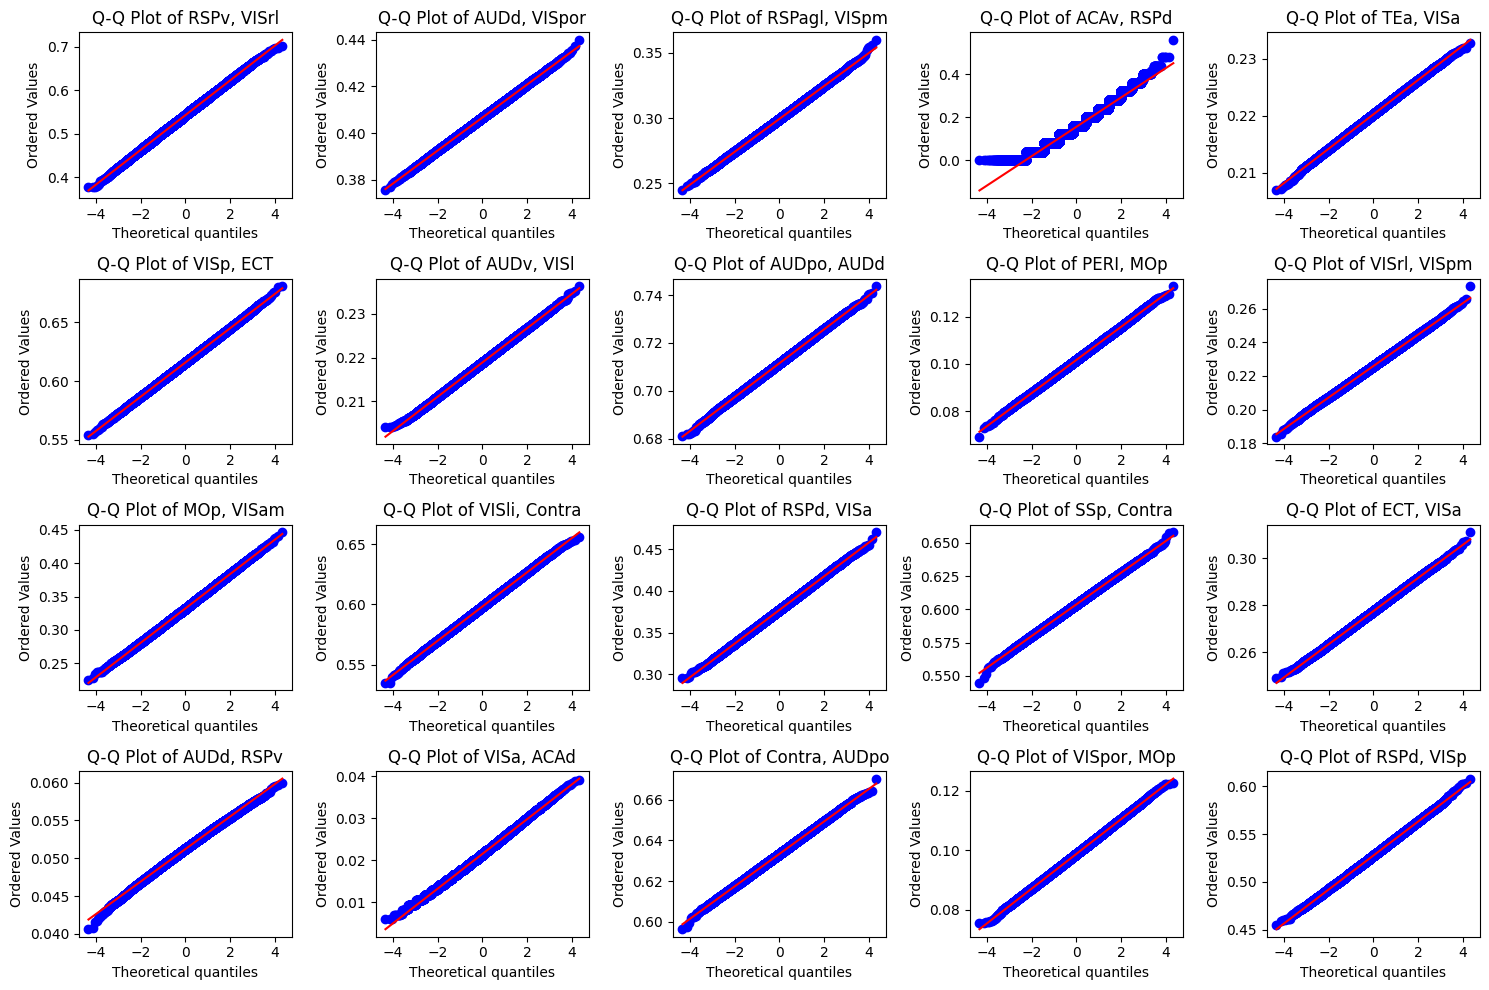

In [4]:
#check normality by plotting random selection qq plots
selected_columns = np.random.choice(shuffled_cond_prob.columns, 20, replace=False)


fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    stats.probplot(shuffled_cond_prob[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot of {col}')

plt.tight_layout()
plt.show()

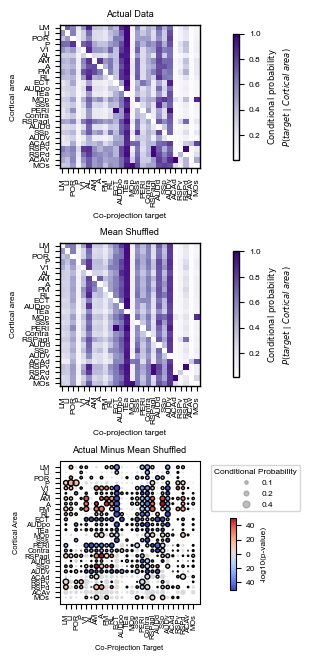

In [5]:

fig, axs = plt.subplots(3, 1, figsize=(3, 6.5), constrained_layout=True)
heatmap_titles = ['Actual Data', 'Mean Shuffled']

analysis_type = 'cubelet'

if analysis_type != 'main':
    actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
else:
    actual_data = conditional_probability_dict['area_is_main']

combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']

dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}']]

cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
all_cols = actual_data.columns
cols = [col for col in cols if col in all_cols]

for number, title in enumerate(heatmap_titles):
    data_to_use = dfs[number].copy(deep=True)
    shortened_data = data_to_use.loc[all_cols]

    sb.heatmap(
        ax=axs[number],
        data=fpf.convert_matrix_names(shortened_data),
        cmap='Purples',
        xticklabels=True,
        yticklabels=True, cbar_kws=dict(
            location='right',  
            pad=-0.48,          
                                
            fraction=0.045,     
            shrink=1.0,         
            use_gridspec=True   
        )
    )

    axs[number].set_title(f'{heatmap_titles[number]}', size=font_size*1.1)
    axs[number].tick_params(axis='y', which='major', labelsize=font_size, rotation=0)

    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    axs[number].set_ylabel('Cortical area', size=font_size)
    axs[number].set_xlabel('Co-projection target', size=font_size)

    cbar = axs[number].collections[0].colorbar
    
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    cbar.set_label(
    r'$\mathrm{Conditional\ probability}$' + '\n' +
    r'$\mathit{P(target \mid Cortical\ area)}$',
    fontsize=font_size
)

    #cbar.set_label(r'Conditional probability' '\n' r'$\mathit{P(target \mid Cortical\ area)}$', fontsize=font_size)
bubble_data = fpf.convert_matrix_names(combined_dif.loc[all_cols])
pval_df = fpf.convert_matrix_names(p_val_dict[f'all_columns'].loc[all_cols])

df_plot = bubble_data.stack().reset_index()
df_plot.columns = ["y_label", "x_label", "conditional_prob"]
df_plot["p_value"] = pval_df.stack().reset_index(drop=True)
x_categories = bubble_data.columns
y_categories = bubble_data.index

df_plot["x"] = pd.Categorical(df_plot["x_label"], categories=x_categories, ordered=True).codes
df_plot["y"] = pd.Categorical(df_plot["y_label"], categories=y_categories, ordered=True).codes

size_scale = 60
df_plot["bubble_size"] = df_plot["conditional_prob"].abs() * size_scale
#df_plot["color_value"] = -np.log10(df_plot["p_value"].clip(lower=1e-50))
df_plot["color_value"] = (
        np.sign(df_plot["conditional_prob"]) *
        -np.log10(df_plot["p_value"].clip(lower=1e-50))
    )
norm = TwoSlopeNorm(vmin=df_plot["color_value"].min(),
                    vcenter=0,
                    vmax=df_plot["color_value"].max())

sc = axs[2].scatter(
    x=df_plot["x"],
    y=df_plot["y"],
    s=df_plot["bubble_size"],
    c=df_plot["color_value"],
    cmap='coolwarm', norm=norm,
    edgecolors="none"
)
significant_mask = df_plot["p_value"] < 0.05
axs[2].scatter(
    x=df_plot.loc[significant_mask, "x"],
    y=df_plot.loc[significant_mask, "y"],
    s=df_plot.loc[significant_mask, "bubble_size"],
    facecolors="none",
    edgecolors="black",
    linewidths=1
)
axs[2].set_xticks(range(len(x_categories)))
axs[2].set_yticks(range(len(y_categories)))
axs[2].set_xticklabels(x_categories, rotation=90, fontsize=font_size*0.9)
axs[2].set_yticklabels(y_categories, fontsize=font_size*0.9)

axs[2].invert_yaxis()
axs[2].set_title('Actual Minus Mean Shuffled', size=font_size*1.1)
axs[2].set_xlabel("Co-Projection Target", fontsize=font_size*0.9)
axs[2].set_ylabel("Cortical Area", fontsize=font_size*0.9)
legend_values = [0.1, 0.2, 0.4]
legend_handles = [
    axs[2].scatter([], [], s=val * size_scale, c="gray", alpha=0.5,
                   label=f'{val:.1f}') for val in legend_values
]

axs[2].legend(
    handles=legend_handles,
    title="Conditional Probability",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    frameon=True,
    fontsize=font_size,
    title_fontsize=font_size,
)
cax = inset_axes(
    axs[2],                  
    width="4%",            
    height="50%",             
    bbox_to_anchor=(1.22,    
                    -0.4,   
                    1, 1),
    bbox_transform=axs[2].transAxes,
    loc="upper left",
    borderpad=0,
)

cbar = plt.colorbar(sc, cax=cax, orientation="vertical")
cbar.set_label("-log10(p-value)", fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
tick_locs = cbar.get_ticks()
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([f"{int(abs(tick))}" for tick in tick_locs])
fig.savefig(f"{saving_path}/supplementary/extended_fig_3d.svg", format="svg", bbox_inches='tight')



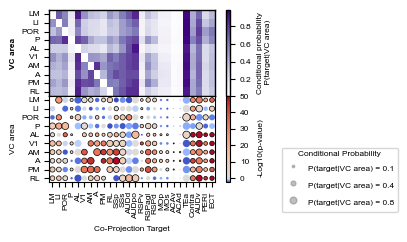

In [9]:

analysis_type = 'cubelet'

if analysis_type != 'main':
    actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
elif analysis_type == 'main':
    actual_data = conditional_probability_dict['area_is_main']

cols = [ 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISal', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#all_cols = actual_data.columns
pairwise_distances = actual_data.corr() 
linkage_matrix = linkage(pairwise_distances, method='ward')
dendro = dendrogram(linkage_matrix, labels=actual_data.columns, no_plot=True)
column_order = dendro['ivl']
all_cols = column_order
cols = [col for col in cols if col in all_cols]
not_in = [col for col in all_cols if col not in cols]
combined = cols + not_in
shortened_data = actual_data.loc[cols][combined]
shortened_data_names_the_same = actual_data.loc[cols][combined].copy(deep=True)
fig, axs = plt.subplots(
    2, 1,
    figsize=(4.2, 2.4),
    sharex=True,  # share x-axis between plots
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.0}  # reduce space between subplots
)

ax1 = axs[0]
plt.sca(ax1)
tick_vals= [0.0, 0.2, 0.4, 0.6, 0.8, 1]
sb.heatmap(
    data=fpf.convert_matrix_names(shortened_data), 
    cmap='Purples',
    xticklabels=False,  
    yticklabels=True, 
    cbar_kws={'label': 'conditional probability','ticks': tick_vals},
    ax=ax1
)

ax1.tick_params(axis='y', which='major', labelsize=font_size, rotation=0)
#ax1.tick_params(axis='x', which='major', labelsize=7, rotation=90)
for _, spine in ax1.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax1.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label(r'Conditional probability' '\n' r'$\mathit{P(target \mid Vc\ area)}$', fontsize=font_size)
cbar.set_label('Conditional probability\n P(target|VC area)',
    fontsize=font_size
)
# for ii in shortened_data_names_the_same.index:
#     for j in shortened_data_names_the_same.columns:
#         if p_val_dict['shuff_cubelet'].loc[ii, j] > 0.05:
#             row_idx = shortened_data_names_the_same.index.get_loc(ii)
#             col_idx = shortened_data_names_the_same.columns.get_loc(j)
#             ax1.add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=1))

ax1.set_ylabel('VC area', size=font_size, fontweight='bold')
ax1.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

ax2 = axs[1]
plt.sca(ax2)  

converted_actual = fpf.convert_matrix_names(actual_data.loc[cols][combined])
p_val_converted = fpf.convert_matrix_names(p_val_dict['shuff_cubelet'].loc[cols][combined])

df_plot = converted_actual.stack().reset_index()
df_plot.columns = ["y_label", "x_label", "conditional_prob"]
df_plot["p_value"] = p_val_converted.stack().reset_index(drop=True)

x_categories = converted_actual.columns
y_categories = converted_actual.index
df_plot["x"] = (
    pd.Categorical(df_plot["x_label"], categories=x_categories, ordered=True).codes + 0.5
)

df_plot["y"] = pd.Categorical(df_plot["y_label"], categories=y_categories, ordered=True).codes

size_scale = 30
df_plot["bubble_size"] = df_plot["conditional_prob"].abs() * size_scale
#df_plot["color_value"] = -np.log10(df_plot["p_value"].clip(lower=1e-50))
df_plot["color_value"] = (
        np.sign(df_plot["conditional_prob"]) *
        -np.log10(df_plot["p_value"].clip(lower=1e-50))
    )
norm = TwoSlopeNorm(vmin=df_plot["color_value"].min(),
                    vcenter=0,
                    vmax=df_plot["color_value"].max())

sc = ax2.scatter(
    x=df_plot["x"],
    y=df_plot["y"],
    s=df_plot["bubble_size"],
    c=df_plot["color_value"],
    cmap='coolwarm', norm=norm,
    edgecolors="none"
)

df_signif = df_plot[df_plot["p_value"] < 0.05]

ax2.scatter(
    x=df_signif["x"],
    y=df_signif["y"],
    s=df_signif["bubble_size"],
    facecolors="none",
    edgecolors="black",
    linewidths=0.5
)

cbar = fig.colorbar(sc, ax=ax2)
cbar.set_label("-Log10(p-value)", fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
cbar.ax.yaxis.set_label_position('right')  # Move label to left
cbar.ax.yaxis.set_label_coords(7.5, 0.4)
legend_values = [0.1, 0.4, 0.8]
legend_handles = [
    ax2.scatter([], [], s=val * size_scale, c="gray", alpha=0.5, 
                label=f"P(target|VC area) = {val}")  
    for val in legend_values
]

legend = ax2.legend(
    handles=legend_handles,
    title="Conditional Probability",
    loc="upper left",
    bbox_to_anchor=(1.4, 0.4),
    borderaxespad=0.,
    frameon=True,
    handleheight=2.0,
    fontsize=font_size, title_fontsize=font_size
)


ax2.set_yticks(range(len(y_categories)))
ax2.set_yticklabels(y_categories, fontsize=font_size)
tick_positions = np.arange(len(x_categories)) + 0.5
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(x_categories, rotation=90, fontsize=font_size)
ax2.invert_yaxis()

ax2.set_xlabel("Co-Projection Target", fontsize=font_size)
ax2.set_ylabel("VC area", fontsize=font_size)

plt.tight_layout()
plt.savefig(f"{saving_path}/fig_2_heatmapbubble_combined.svg", format="svg")
plt.show()


In [10]:
#plot mean cosine similarity of conditional probabilities
#let's first calculate the mean conditional probability across mice
key='homogenous_across_cubelet'
which = 'cubelet'
shuff = f'shuff_{which}'
common_cols = all_combined[key].columns

cols = [ 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISal', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cond_prob_dict = {}
shuff_cond_prob_dict = {}
mouse_cond_prob_minus_shuff = {}
for mouse in mice:
    cond_prob_dict[mouse]= fpf.get_cond_prob(matrix = combined_dict[mouse][key], columns = cols_reordered, index = cols_reordered)
    shuff_cond_prob_dict[mouse] = fpf.get_cond_prob(matrix = combined_dict[mouse][shuff], columns = cols_reordered, index = cols_reordered)
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob_{mouse}_collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
    #shuff_cond_prob_dict[mouse] = mean_val_matrix
    mouse_cond_prob_minus_shuff[mouse] = cond_prob_dict[mouse]-mean_val_matrix



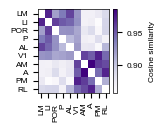

In [11]:
# plt.figure(figsize=(1.5, 1.1), constrained_layout=True)
fig, ax = plt.subplots(figsize=(1.55, 1.2), constrained_layout=True)
dict_to_look = cond_prob_dict  # Only use the first dictionary
title = 'Actual'

cosine_dict = {}
for mouse in mice:
    cosine_dict[mouse] = fpf.get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols=cols)

# Calculate cosine similarity to itself
# to_itself_cosine = {}
# for area in cols:
#     area_list = []
#     for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
#         neurons_1 = dict_to_look[mouse_a].loc[area].drop([area])
#         neurons_2 = dict_to_look[mouse_b].loc[area].drop([area])
#         bl = np.array(neurons_1).reshape(1, -1)
#         bl_2 = np.array(neurons_2).reshape(1, -1)
#         area_list.append(cosine_similarity(bl, bl_2))
#     to_itself_cosine[area] = np.mean(area_list)

cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
cosine_df = cosine_df.loc[cols][cols]
# for col in cols:
#     cosine_df.loc[col, col] = to_itself_cosine[col]

sb.heatmap(
    data=fpf.convert_matrix_names(cosine_df),
    cmap='Purples', #'RdBu_r',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Cosine similarity'}
)


plt.tick_params(axis='y', which='major', labelsize=font_size, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=font_size, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Cosine similarity', fontsize=font_size)
fig.savefig(f"{saving_path}/fig_2_cosine_sim.svg", format="svg")
plt.show()


In [12]:
shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated.pkl')
shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_cubelet__collated.pkl')
    

In [13]:
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'

dot_size = 3
alpha_val = 0.5

In [14]:
dorsal_stream = ['VISa', 'VISam', 'VISpm', 'VISrl']
ventral_stream = ['VISpor', 'VISpl', 'VISl', 'VISli', 'VISal']
from scipy.stats import norm

barcodes = all_combined['homogenous_across_cubelet']
total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
all_cols = barcodes.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in all_cols]
probs_df = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'p_value'])  
for column_name in shuffled_2_combinations.columns:
    if any(substring in column_name for substring in cols):
        col, col_2= map(str.strip, column_name.split(','))
# for col in cols_reordered:
#     for col_2 in cols_reordered:
#         if col != col_2:
        if col in all_cols and col_2 in all_cols:
            prob_df = pd.DataFrame()
            prob_df["a"] = barcodes[col].astype(bool)
            prob_df["b"] = barcodes[col_2].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            probs_actual = prob_df["matching"].sum() / len(barcodes)
            probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
            probs_df.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
            probs_df.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
            if f'{col}, {col_2}' in shuffled_2_combinations.columns:
                column_name = f'{col}, {col_2}'
            elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
                column_name = f'{col_2}, {col}'
            shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
            shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers[0]) * (shuffled_numbers[col_2]/shuffle_total_numbers[0])
            # shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
            # shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
            shuff_effect = (shuff_actual_prob/shuff_joint_prob).astype(float)
            shuff_log_effect = np.log2(shuff_effect+1e-3)
            mean_shuff_log_effect = shuff_log_effect.mean()
            # actual_odds = (probs_actual) / (1 - (probs_actual))
            # joint_odds = (probs_joint) / (1 - (probs_joint))
            actual_effect = probs_actual/probs_joint
            # probs_df.loc['odds_actual', f'{col}, {col_2}'] = probs_actual
            # probs_df.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
            probs_df.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_effect
            #probs_df.loc['mean_shuf_subtracted', f'{col}, {col_2}'] = np.log2(actual_effect - shuff_effect.mean())
            probs_df.loc['log_OR_actual', f'{col}, {col_2}'] = np.log2(actual_effect +1e-3)
            mu, std = norm.fit(shuff_effect)
            if actual_effect >= shuff_effect.mean():
                p_val = norm.sf(actual_effect, loc=mu, scale=std) * 2  # two-sided
            else:
                p_val = norm.cdf(actual_effect, loc=mu, scale=std) * 2
            # if OR_actual >= oddd.mean():
            #     p_val = ((sum(1 for value in oddd if value > OR_actual)+1)/(len(oddd)+1))*2
            # elif val_to_comp < mean_corr:
            #     p_val = ((sum(1 for value in oddd if value < OR_actual)+1)/(len(oddd)+1))*2 
            p_val_adj = p_val* total_combinations
            probs_df.loc['p_value', f'{col}, {col_2}'] = p_val_adj
to_plot = probs_df.T
to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']


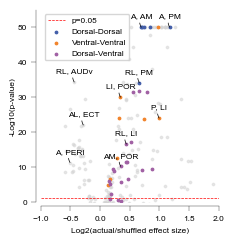

In [15]:
colors_to_colour = ff.get_colour_dict()
alpha_val_stream = 1
to_plot['-log10_p_value'] = to_plot['-log10_p_value'].clip(upper=50)
to_plot['stream'] = to_plot.index.map(classify_stream)
fig, ax = plt.subplots(figsize=(2.3, 2.5))
plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color=colors_to_colour['OUT'], s=dot_size, alpha=alpha_val)

plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color=colors_to_colour['dorsal'], alpha=alpha_val_stream, s=dot_size, label='Dorsal-Dorsal'
)

plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color=colors_to_colour['ventral'], alpha=alpha_val_stream, s=dot_size, label='Ventral-Ventral'
)


plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color=colors_to_colour['dorso-ventral'], alpha=alpha_val_stream, s=dot_size, label='Dorsal-Ventral'
)


plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=0.5, label='p=0.05')  # Horizontal line at p=0.05
convert_dict = ff.get_convert_dict()

#areas_to_check = ['VISrl, AUDv', 'VISal, ECT',  'VISa, PERI', 'VISa, VISam', 'VISpl, VISli', 'VISpor, VISam', 'VISa, VISpm', 'VISpor, VISli', 'VISrl, VISli', 'VISrl, VISpm']
areas_to_check = ['VISrl, AUDv', 'VISal, ECT', 'VISa, PERI','VISa, VISam', 'VISpl, VISli', 'VISam, VISpor', 'VISa, VISpm', 'VISli, VISpor', 'VISrl, VISli', 'VISrl, VISpm']
for pair in areas_to_check:
    areas = pair.split(', ') 
    x_val = to_plot.loc[pair, 'shuf-sub']
    y_val = to_plot.loc[pair, '-log10_p_value']
    offset_y = y_val + 2
    if areas[0] in convert_dict:
        areas[0] = convert_dict[areas[0]]
    if areas[1] in convert_dict:
        areas[1] = convert_dict[areas[1]]
    plt.annotate(
                f'{areas[0]}, {areas[1]}', 
                xy=(x_val, y_val), 
                xytext=(x_val, offset_y),  
                fontsize=font_size, ha='center', va='bottom', color='black',
                arrowprops=dict(
                    arrowstyle="-", color="black", linewidth=0.5, alpha=1, shrinkA=0,  
    shrinkB=0,
                    connectionstyle="arc3,rad=0.3"
                )  
            )


xlabel ='Log2(actual/shuffled effect size)'
ylabel = '-Log10(p-value)'

plt.ylim(0, 55)
plt.xlim(-1, 2)
plt.legend(loc='upper left', prop={'size': font_size})
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= ylabel, xtitle=xlabel, title='', mySize =font_size)
fig.savefig(f"{saving_path}/fig2_motif_volcanoplot.svg", format="svg")
plt.show()


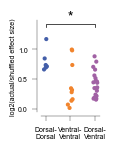

Dorsal-Dorsal vs Dorsal-Ventral: U=109.000, p=0.0015
Ventral-Ventral vs Dorsal-Ventral: U=79.000, p=0.3671


In [32]:
# from scipy.stats import mannwhitneyu
# import textwrap

# # Rename stream values for better labels
# stream_label_map = {
#     'dorsal': 'Dorsal-Dorsal',
#     'ventral': 'Ventral-Ventral',
#     'dorsal-ventral': 'Dorsal-Ventral',
#     'other': 'Other'
# }
# to_plot['stream_label'] = to_plot['stream'].map(stream_label_map)

# # Set custom order for plotting
# stream_order = ['Dorsal-Dorsal', 'Ventral-Ventral', 'Dorsal-Ventral']

# # Filter to only the streams we're interested in
# plot_data = to_plot[to_plot['stream_label'].isin(stream_order)]

# # Wrap labels to ensure narrower plot
# wrapped_labels = [textwrap.fill(label, width=8) for label in stream_order]

# # Plotting
# fig, ax = plt.subplots(figsize=(1.1, 1.6))  # narrower figure

# # Prepare data for statistics
# dd = plot_data[plot_data['stream_label'] == 'Dorsal-Dorsal']['shuf-sub']
# vv = plot_data[plot_data['stream_label'] == 'Ventral-Ventral']['shuf-sub']
# dv = plot_data[plot_data['stream_label'] == 'Dorsal-Ventral']['shuf-sub']

# stat_dd_dv, p_dd_dv = mannwhitneyu(dd, dv, alternative='two-sided')
# stat_vv_dv, p_vv_dv = mannwhitneyu(vv, dv, alternative='two-sided')

# # Create plot
# sb.stripplot(
#     data=plot_data,
#     x='stream_label',
#     y='shuf-sub', s=3,
#     palette={
#         'Dorsal-Dorsal': colors_to_colour['dorsal'],
#         'Ventral-Ventral': colors_to_colour['ventral'],
#         'Dorsal-Ventral': colors_to_colour['dorso-ventral']
#     },
#     order=stream_order
# )

# # Update wrapped x-axis labels
# ax.set_xticklabels(wrapped_labels, rotation=20, fontsize=5)

# # Add significance markers
# y_max = plot_data['shuf-sub'].max()
# bar_height = y_max + 0.2
# text_offset = 0.05
# line_width = 0.5

# def add_sig_marker(x1, x2, y, p_val):
#     if p_val < 0.05:
#         ax.plot([x1, x1, x2, x2], [y, y + text_offset, y + text_offset, y], lw=line_width, color='black')
#         ax.text((x1 + x2) / 2, y + text_offset + 0.02, '*', ha='center', va='bottom', color='black', fontsize=10)

# # Add markers if significant
# if p_dd_dv < 0.05:
#     add_sig_marker(0, 2, bar_height, p_dd_dv)
#     bar_height += 0.2
# if p_vv_dv < 0.05:
#     add_sig_marker(1, 2, bar_height, p_vv_dv)

# ylabel ='log2(actual/shuffled effect size)'

# plt.tight_layout()
# ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle=ylabel, xtitle='', title='', mySize=5)
# plt.show()
# fig.savefig(f"{saving_path}/fig2_stream_effectsize.svg", format="svg")

# print(f"Dorsal-Dorsal vs Dorsal-Ventral: U={stat_dd_dv:.3f}, p={p_dd_dv:.4f}")
# print(f"Ventral-Ventral vs Dorsal-Ventral: U={stat_vv_dv:.3f}, p={p_vv_dv:.4f}")


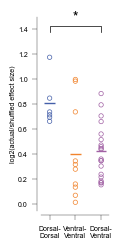

Dorsal-Dorsal vs Dorsal-Ventral: U=109.000, p=0.0015
Ventral-Ventral vs Dorsal-Ventral: U=79.000, p=0.3671


In [43]:

stream_label_map = {
    'dorsal': 'Dorsal-Dorsal',
    'ventral': 'Ventral-Ventral',
    'dorsal-ventral': 'Dorsal-Ventral',
    'other': 'Other'
}
to_plot['stream_label'] = to_plot['stream'].map(stream_label_map)
stream_order = ['Dorsal-Dorsal', 'Ventral-Ventral', 'Dorsal-Ventral']
plot_data = to_plot[to_plot['stream_label'].isin(stream_order)]
wrapped_labels = [textwrap.fill(label, width=8) for label in stream_order]
fig, ax = plt.subplots(figsize=(1.1, 2.5))
dd = plot_data[plot_data['stream_label'] == 'Dorsal-Dorsal']['shuf-sub']
vv = plot_data[plot_data['stream_label'] == 'Ventral-Ventral']['shuf-sub']
dv = plot_data[plot_data['stream_label'] == 'Dorsal-Ventral']['shuf-sub']

stat_dd_dv, p_dd_dv = mannwhitneyu(dd, dv, alternative='two-sided')
stat_vv_dv, p_vv_dv = mannwhitneyu(vv, dv, alternative='two-sided')
colors_dict = {
    'Dorsal-Dorsal': colors_to_colour['dorsal'],
    'Ventral-Ventral': colors_to_colour['ventral'],
    'Dorsal-Ventral': colors_to_colour['dorso-ventral']
}

for i, key in enumerate(stream_order):
    values = plot_data[plot_data['stream_label'] == key]['shuf-sub'].values
    xvals = np.full(len(values), i)
    color = colors_dict[key]

    ax.scatter(
        xvals, values,
        marker='o',
        facecolors='none',
        edgecolors=color,
        linewidth=0.5,
        s=10  
    )
    mean_val = np.mean(values)
    ax.hlines(
        y=mean_val,
        xmin=i - 0.2,
        xmax=i + 0.2,
        colors=color,
        linewidth=1
    )

ax.set_xticks(range(len(stream_order)))
ax.set_xticklabels(wrapped_labels, rotation=20, fontsize=5)
y_max = plot_data['shuf-sub'].max()
bar_height = y_max + 0.2
text_offset = 0.05
line_width = 0.5

def add_sig_marker(x1, x2, y, p_val):
    if p_val < 0.05:
        ax.plot([x1, x1, x2, x2], [y, y + text_offset, y + text_offset, y],
                lw=line_width, color='black')
        ax.text((x1 + x2) / 2, y + text_offset + 0.02, '*', 
                ha='center', va='bottom', color='black', fontsize=10)
if p_dd_dv < 0.05:
    add_sig_marker(0, 2, bar_height, p_dd_dv)
    bar_height += 0.2
if p_vv_dv < 0.05:
    add_sig_marker(1, 2, bar_height, p_vv_dv)

ylabel ='log2(actual/shuffled effect size)'

plt.tight_layout()
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle=ylabel, xtitle='', title='', mySize=5)
fig.savefig(f"{saving_path}/fig2_stream_effectsize.svg", format="svg")
plt.show()

print(f"Dorsal-Dorsal vs Dorsal-Ventral: U={stat_dd_dv:.3f}, p={p_dd_dv:.4f}")
print(f"Ventral-Ventral vs Dorsal-Ventral: U={stat_vv_dv:.3f}, p={p_vv_dv:.4f}")


Now plot differences in frequency of targeting against AP soma position

In [15]:
# proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
with open("general_analysis_parameters.yaml", "r") as file:
    gen_parameters = yaml.safe_load(file)
proj_path = gen_parameters['proj_path']
HVA_cols = gen_parameters['HVA_cols'] #['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']

mice = gen_parameters['MICE']
combined_mice_dict = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"{proj_path}/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    barcodes = barcodes[barcodes.astype(bool).sum(axis=1)>0]
    new_dict['homog_across_cubelet'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, remove_AUDp_vis_cub=True)
    combined_mice_dict[mouse] = new_dict

In [16]:
#not ness since no barcodes are shared between mice, but in case of re-use
# def add_prefix_to_index(df, prefix):
#     df = df.copy()  # Avoid modifying the original DataFrame
#     df.index = [f"{prefix}_{idx}" for idx in df.index]
#     return df
index_adj_combined_dict = {}

for mouse in mice:
    index_adj_combined_dict[mouse] = fpf.add_prefix_to_index(combined_mice_dict[mouse]['homog_across_cubelet'], mouse)



In [17]:
key = 'homog_across_cubelet'
common_cols_cortex = fpf.get_common_columns(mice= mice, combined_dict=combined_mice_dict, key=key, cortex=True)
combine_all_mice = pd.concat([
    index_adj_combined_dict[k][common_cols_cortex] for k in mice
])
which_mice = pd.DataFrame(columns = ['mice'], index= combine_all_mice.index)
for k in mice:
    which_mice.loc[index_adj_combined_dict[k].index, 'mice'] = k



In [18]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)
max_y_vis = np.max(indices_VIS[:, 0])
min_y_vis = np.min(indices_VIS[:, 0])
#select anterior and posterior parts of A1
max_y = np.max(indices_AUDp[:, 0])
min_y = np.min(indices_AUDp[:, 0])
# AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
#lets get the coordinates for the centre of A1
A1_masked = contra_mask * AUDp_mask
A1_centroid_coords = np.argwhere(A1_masked == 1).mean(axis=0)

#now lets load the barcodes
proj_path = pathlib.Path(proj_path)
#mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']

mouse_dict_AP_source = {}
mouse_dict_AP_VC = {}
mouse_barcodes_by_source = {}
mouse_vis_main_dict = {}
mouse_vis_coord = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    AP_position_dict = {}
    AP_position_vis_dict = {}
    vis_main_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    barcodes_no_soma = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded.pkl")
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    all_VIS_ROI = np.unique(ROI_3D *  VIS_mask * contra_mask)
    vis_coord = {}
    #lets make sure we keep the same criteria of removing VIS rois where more than 10% is in AUDp
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes_no_soma.columns,
        lcm_directory=lcm_directory,
        area_threshold=0.1,
    )
    #HVA_cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    frac = areas_only_grouped.div(areas_only_grouped.sum(axis=1), axis=0)
    frac_filtered = frac.loc[(frac[HVA_cols].gt(0).any(axis=1)) & (frac['AUDp'] > 0.1)].index
    all_VIS_ROI = [sample for sample in all_VIS_ROI if sample != 0 and sample in barcodes_no_soma.columns and sample not in frac_filtered and areas_only_grouped[HVA_cols].loc[sample].sum()>0]

    for sample in all_VIS_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        vis_coord[sample] = centroid
        AP_position_vis_dict[sample] = max_y_vis - centroid[0] #centroid[0]-min_y_vis
        vis_main_dict[sample] = areas_only_grouped[HVA_cols].loc[sample].idxmax()
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = max_y - centroid[0]#-min_y#AP_midpoint_A1
    mouse_dict_AP_source[mouse]=AP_position_dict
    mouse_dict_AP_VC[mouse] = AP_position_vis_dict
    mouse_vis_main_dict[mouse] = vis_main_dict
    mouse_vis_coord[mouse] = vis_coord

In [19]:
#lets get the coordinates for the centre of A1
A1_masked = contra_mask * AUDp_mask
A1_centroid_coords = np.argwhere(A1_masked == 1).mean(axis=0)
vis_ipsi = VIS_mask * contra_mask
VC_centroid_coords = np.argwhere(vis_ipsi == 1).mean(axis=0)
# get list of sources from each barcode, then create a dictionary
#soma = pd.DataFrame(barcodes.idxmax(axis=1))
def get_AP_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found
#make a dataframe with mean AP_pos of sample, mouse and AP_soma
AP_soma_VC_sample = pd.DataFrame(columns=['Mouse', 'mean_AP_soma', 'AP_Vis', 'VC_majority', 'dist_3d', 'sample'])
AP_soma_VC_sample_all = pd.DataFrame(columns=['Mouse', 'actual_AP_soma', 'AP_Vis'])
barcodes_dict = {}
AP_position_dict_list = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"{proj_path}/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    barcodes= fpf.add_prefix_to_index(barcodes, mouse)
    soma = pd.DataFrame(barcodes.idxmax(axis=1))
    soma['AP_position'] = soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source[mouse]), axis=1)
    soma['mouse'] = mouse
    #soma['uncorrected_AP']= soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source_uncorrected[mouse]), axis=1)
    for sample in mouse_dict_AP_VC[mouse].keys():
        indices_for_sample = barcodes[barcodes[sample]>0].index
        if len(indices_for_sample)>2:
            mean_AP=np.mean(soma.loc[indices_for_sample]['AP_position'])
            uncorrected_meanAP = -(mean_AP) + max_y #back to non-normalised
            A1_coord_updated = [uncorrected_meanAP, A1_centroid_coords[1], A1_centroid_coords[2]]
            vis_cubelet_coord_updated = [mouse_vis_coord[mouse][sample][0], VC_centroid_coords[1], VC_centroid_coords[2]]
            dist_3d = np.linalg.norm(np.array(A1_coord_updated) - np.array(vis_cubelet_coord_updated)) * 25
            new_row= pd.DataFrame({'Mouse':[mouse], 'mean_AP_soma':[mean_AP*25], 'AP_Vis':[mouse_dict_AP_VC[mouse][sample]*25], 'VC_majority': [mouse_vis_main_dict[mouse][sample]], 'dist_3d': [dist_3d], 'sample': [sample]})
            # bl = pd.DataFrame()
            # bl['AP_postion'] = soma.loc[indices_for_sample]['AP_position']
            # bl['Mouse'] = mouse
            # bl['actual_AP_soma'] = mouse_dict_AP_VC[mouse][sample]
            AP_soma_VC_sample = pd.concat([AP_soma_VC_sample, new_row])
            #AP_soma_VC_sample_all = pd.concat([AP_soma_VC_sample_all, bl])
    #barcodes_dict[mouse] = barcodes_assigned_area.drop(columns=['AUDp'])
    #soma_filtered = soma.loc[combined_mice_dict[mouse]['homog_across_cubelet'].index]
    AP_position_dict_list[mouse] = soma#soma_filtered
    # mouse_euclidean_dist[mouse] = euclidean_dist

AP_position_dict_list_combined = pd.concat([
    AP_position_dict_list[k] for k in mice
])

In [20]:

convert_dict = ff.get_convert_dict()#{
#     "VISl": "LM",
#     "VISrl": "RL",
#     "VISal": "AL",
#     "VISa": "A",
#     "VISp": "V1",
#     "VISpor": "POR",
#     "VISli": "LI",
#     "VISpl": "P",
#     "VISpm": "PM",
#     "VISam": "AM"
# }
which_colour = ff.get_colour_dict(allen_nomenclature=True)
AP_soma_VC_sample['converted'] = AP_soma_VC_sample['VC_majority'].map(convert_dict)
which_colour_other = ff.get_colour_dict(allen_nomenclature=False)

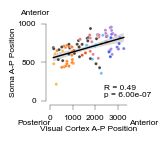

In [21]:
rho, pval = pearsonr(AP_soma_VC_sample['AP_Vis'], AP_soma_VC_sample['mean_AP_soma'])
saving_path = gen_parameters['fig_saving_path']
font_size = gen_parameters['font_size']
# Plotting regression plot with confidence interval
# plt.figure(figsize=(4, 3))
fig, ax = plt.subplots(figsize=(1, 1)) 
sb.regplot(
    x='AP_Vis',
    y='mean_AP_soma',
    data=AP_soma_VC_sample, color='black', scatter=False,
    ci=95, scatter_kws={'s':5}, line_kws={'linewidth':1}
)
scatter = sb.scatterplot(
    x='AP_Vis', 
    y='mean_AP_soma', 
    data=AP_soma_VC_sample, 
    hue='converted', legend=False,
    palette=which_colour_other,  # Apply color mapping from dictionary
    s=5  # Scatter point size
)
handles, labels = scatter.get_legend_handles_labels()
# ax.legend(
#     handles=handles, 
#     labels=labels, 
#     title="VC area", title_fontsize=font_size,
#     bbox_to_anchor=(1.3, -0.3),  
#     loc='lower left', 
#     borderaxespad=0, 
#     fontsize=font_size, 
#     handlelength=1,
#     handletextpad=0.4,
#     markerscale=0.2)

plt.text(
    0.7, 0.2,
    f"R = {rho:.2f}\np = {pval:.2e}",
    ha='left',
    va='top',
    transform=plt.gca().transAxes,
    fontsize=font_size,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0)
)

# Axis labels
xlabel = 'Visual Cortex A-P Position'
ylabel = 'Soma A-P Position'

# Add Anterior/Posterior labels
#plt.text(-0.02, -0.16, 'Posterior', transform=plt.gca().transAxes, fontsize=8, ha='left', va='bottom')

plt.text(1.4, -0.33, 'Anterior', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=font_size)
plt.text(-0.2, 1.1, 'Anterior', ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=font_size)
plt.text(-0.2, -0.33, 'Posterior', transform=plt.gca().transAxes, fontsize=font_size, va='bottom', ha='center')
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= ylabel, xtitle=xlabel, title='', mySize =gen_parameters['font_size'])
# plt.xlim(left=0)
# plt.ylim(bottom=0)
#plt.tight_layout()
plt.xticks([0, 1000, 2000, 3000])
plt.yticks([0, 500, 1000])
fig.savefig(f"{saving_path}/fig_2_AP_vs_VISAP.svg", format="svg")
plt.show()


In [16]:
#if it was mainly Euclidean distance driving AP patterning, 
# we would expect AP cubelet bins with the same euclidean distance to a given soma AP position to have the same liklihood of projecting
# we would expect the soma location for each VC projection to be more likely to be in equivalent AP position versus the closest distance
#first lets split AC and VC into bins of 10 AP positions
#next, for each VC bin, lets find the AC bin that is closest in euclidean distance
#then lets find the bin that is closest in AP ranking
#for each neuron targeting the VC, we ask if it is more likely to have a soma in equivalent AP bin or in closest distance bin, how does this comp to random bin?

In [22]:
#n_bins = 8
n_ac_bins = 4
n_vc_bins = 4

ac_span = (max_y - min_y)*25   
vc_span = (max_y_vis - min_y_vis) *25 
ac_bin_edges = np.linspace(0, ac_span, n_ac_bins + 1)
vc_bin_edges = np.linspace(0, vc_span, n_vc_bins + 1)
def get_bin_id(x, edges):
    # np.searchsorted(..., side='right') returns the index of the bin to the right
    # subtract 1 so that an x that’s just below edges[i] ends up in bin i-1
    return np.searchsorted(edges, x, side='right') - 1
# AP_position_dict_list_combined['AC_bin_id']= AP_position_dict_list_combined['AP_position'].apply(lambda x: get_bin_id(x, ac_bin_edges))
AP_soma_VC_sample['VC_bin_id']= AP_soma_VC_sample['AP_Vis'].apply(lambda x: get_bin_id(x, vc_bin_edges))
data = [
    {'mouse': mouse, 'sample': sample, 'AP': value}
    for mouse, samples in mouse_dict_AP_source.items()
    for sample, value in samples.items()
]

soma_AP_pos = pd.DataFrame(data)
soma_AP_pos['AP_microns']= soma_AP_pos['AP']*25
soma_AP_pos['AC_bin_id']= soma_AP_pos['AP_microns'].apply(lambda x: get_bin_id(x, ac_bin_edges))
soma_AP_pos_A1_only = soma_AP_pos[~soma_AP_pos['AC_bin_id'].isin([-1, n_ac_bins])] #remove bins with centroids outside of A1 (since our initial sorting for annotating AP position in A1 is not on source samples, but any sample that happen to contain some A1)

In [8]:
# # if number of vc bins different to ac bins, we work out which each converts to
# vc_bin_conversion = {}
# conv_factor = n_vc_bins/n_ac_bins
# for val in range(n_vc_bins):
#     ac_bin = int(np.floor(val / conv_factor))
#     ac_bin = min(ac_bin, n_ac_bins - 1)
#     vc_bin_conversion[val] = ac_bin

In [23]:
ac_bin_centers = (ac_bin_edges[:-1] + ac_bin_edges[1:]) / 2
vc_bin_centers = (vc_bin_edges[:-1] + vc_bin_edges[1:]) / 2
ac_bin_dict = {i: center for i, center in enumerate(ac_bin_centers)}
vc_bin_dict = {i: center for i, center in enumerate(vc_bin_centers)}
VC_closest_soma_bin = {}
VC_coord_dict = {}
AC_coord_dict = {}
VC_closest_soma_distances = {}
empty_ac = np.zeros((1320, 800, 1140))
distance_dict = {'ac_bin':[], 'vc_bin': [], 'dist': []}
for bin_2 in range(n_vc_bins):
    reverted_VIS_AP = -(vc_bin_dict[bin_2]/25) + max_y_vis
    VC_coords= [reverted_VIS_AP, VC_centroid_coords[1], VC_centroid_coords[2]]
    VC_coord_dict[bin_2] = [reverted_VIS_AP, VC_centroid_coords[2]]
    dist_dict = {}
    for bin in range(n_ac_bins):
        reverted_soma_AP = -(ac_bin_dict[bin]/25) + max_y
        soma_A1_coords = [reverted_soma_AP, A1_centroid_coords[1], A1_centroid_coords[2]]
        AC_coord_dict[bin] = [reverted_soma_AP, A1_centroid_coords[2]]
        empty_ac[int(soma_A1_coords[0]), int(soma_A1_coords[1]), int(soma_A1_coords[2])] = bin+1
        dist_dict[bin] = np.linalg.norm(np.array(soma_A1_coords) - np.array(VC_coords)) 
        distance_dict['ac_bin'].append(bin)
        distance_dict['vc_bin'].append(bin_2)
        distance_dict['dist'].append(dist_dict[bin]*25)
    min_dist = min(dist_dict, key=dist_dict.get)
    VC_closest_soma_bin[bin_2] = 0
    VC_closest_soma_distances[bin_2] = dist_dict[0] #only plot lines between ac bin zero and the others


In [24]:
all_cortex_id = bg_atlas.structures['Isocortex']['id']
all_cortex = rsp.make_structure_mask([all_cortex_id], direct_only=False)
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)
all_cortex[indices_AUDp] = 2
VIS_mask = rsp.make_structure_mask([669], direct_only=False) 
all_cortex[np.argwhere(AUDp_mask == 1)] = 3

In [25]:
isocortex_id   = bg_atlas.structures['Isocortex']['id']
isocortex_mask = rsp.make_structure_mask([isocortex_id], direct_only=False).astype(np.uint8)

audp_mask      = rsp.make_structure_mask([AUDp_id], direct_only=False)
vis_mask       = rsp.make_structure_mask([669],     direct_only=False)   # VIS

all_cortex              = np.zeros_like(isocortex_mask, dtype=np.uint8)
all_cortex[isocortex_mask == 1] = 1          # all cortex
all_cortex[audp_mask     == 1] = 2           # AUDp
all_cortex[vis_mask      == 1] = 3           # VIS cortex

zproj = all_cortex.max(axis=1)  

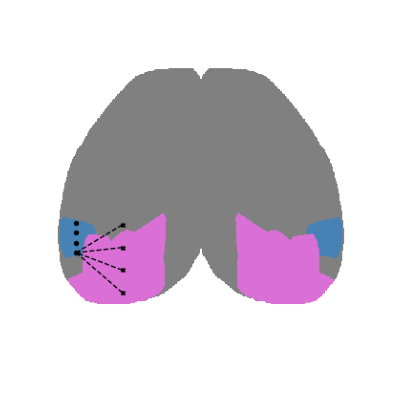

In [81]:
from matplotlib.colors import ListedColormap, BoundaryNorm
fig_size = (4, 4)
fig, ax = plt.subplots(figsize=fig_size)

fig.patch.set_facecolor('white')
ax.set_facecolor('white')
colors = ['white', 'gray', 'steelblue', 'orchid']  # 0: white, 1: red, 2: blue, others: gray
cmap = ListedColormap(colors)
bounds = [0, 0.5, 1.5, 2.5, 255]  # 0-0.5 -> white, 0.5-1.5 -> red, 1.5-2.5 -> blue, others -> gray
norm = BoundaryNorm(bounds, cmap.N)

ax.imshow(zproj.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

font_size = 8
dx, dy = 2, 2
for k, (x, y) in AC_coord_dict.items():
    ax.scatter(x, y, s=8, color='black', zorder=3)
    # ax.text(x + dx, y + dy, str(k), color='black', fontsize=font_size,
    #         ha='left', va='center', zorder=4)

# Plot VC points and links
for k, (x, y) in VC_coord_dict.items():
    ax.scatter(x, y, s=8, color='black', marker='x', zorder=3)
    # ax.text(x + dx, y + dy, str(k), color='black', fontsize=font_size,
    #         ha='left', va='center', zorder=4)

    ac_bin = VC_closest_soma_bin.get(k)
    if ac_bin in AC_coord_dict:
        x_ac, y_ac = AC_coord_dict[ac_bin]
        ax.plot([x, x_ac], [y, y_ac], c='black', linestyle='--', lw=1, alpha=1, zorder=2)

ax.set_axis_off()
plt.tight_layout()
fig.canvas.draw()

w, h = fig.canvas.get_width_height()
plt.close(fig)

img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = img.reshape((h, w, 3))
img_rot = np.rot90(img, k=-1)
img_rf = np.fliplr(img_rot)

plt.figure(figsize=fig_size)
plt.imshow(img_rf)
plt.axis('off')
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/supplementary/fig_s4_AP_vs_dist.svg", format="svg")

In [27]:
#for every AC bin and VC bin combination, what is the fraction of input from that AC bin and distance
distances_df = pd.DataFrame(distance_dict)
distances_df_indiv_mice = pd.concat([distances_df.assign(mouse=mouse) for mouse in mice], ignore_index=True)
distances_df_indiv_mice['frac_input'] = np.nan
distances_df_indiv_mice['total_neurons_in_bin']= np.nan
for ac_bin in range (n_ac_bins):
    comparison_results = {'mouse': [], 'vc_bin': [], 'ac_bin_0_match_ratio': []}
    for vc_bin in range(n_vc_bins):
        for mouse in mice:
            parameters_path = f"{proj_path}/{mouse}/Sequencing"
            barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
            soma = pd.DataFrame(barcodes.idxmax(axis=1))
            samples_in_bin = AP_soma_VC_sample[
                (AP_soma_VC_sample['VC_bin_id'] == vc_bin) &
                (AP_soma_VC_sample['Mouse'] == mouse)
            ]['sample'].to_list()
            valid_samples_in_bin = [s for s in samples_in_bin if s in barcodes.columns]
            soma_indices = barcodes[barcodes[valid_samples_in_bin].sum(axis=1) > 0].index
            soma_filtered = soma.loc[soma_indices]
            total_somas = len(soma_filtered)
            ac_bin_0_samples = soma_AP_pos_A1_only[
                (soma_AP_pos_A1_only['AC_bin_id'] == ac_bin) &
                (soma_AP_pos_A1_only['mouse'] == mouse)
            ]['sample'].to_list()
            ac_bin_0_matches = len(soma_filtered[soma_filtered[0].isin(ac_bin_0_samples)])
            match_ratio = ac_bin_0_matches / total_somas if total_somas > 0 else 0
            comparison_results['mouse'].append(mouse)
            comparison_results['vc_bin'].append(vc_bin)
            comparison_results['ac_bin_0_match_ratio'].append(match_ratio)
            distances_df_indiv_mice.loc[(distances_df_indiv_mice['vc_bin'] == vc_bin) & (distances_df_indiv_mice['mouse'] == mouse) & (distances_df_indiv_mice['ac_bin'] == ac_bin), 'frac_input'] = match_ratio
            distances_df_indiv_mice.loc[(distances_df_indiv_mice['vc_bin'] == vc_bin) & (distances_df_indiv_mice['mouse'] == mouse) & (distances_df_indiv_mice['ac_bin'] == ac_bin), 'total_neurons_in_bin'] = total_somas
    results_df = pd.DataFrame(comparison_results)



In [28]:
distances_df_indiv_mice =pd.DataFrame(distances_df_indiv_mice)
distances_df_indiv_mice['ap_offset'] = (distances_df_indiv_mice['ac_bin'] - distances_df_indiv_mice['vc_bin']).abs()
distances_df_indiv_mice["n_input"]   = (distances_df_indiv_mice["frac_input"] * distances_df_indiv_mice["total_neurons_in_bin"]).round().astype(int)

In [34]:
mean_ap

,ap_bin,frac_input,left,width
0,"(-0.003, 0.75]",0.327154,-0.003,0.753
1,"(0.75, 1.5]",0.305716,0.750,0.750
2,"(1.5, 2.25]",0.187365,1.500,0.750
3,"(2.25, 3.0]",0.053812,2.250,0.750


                    Generalized Linear Model Regression Results                     
Dep. Variable:     ['n_input', 'n_failure']   No. Observations:                   48
Model:                                  GLM   Df Residuals:                       35
Model Family:                      Binomial   Df Model:                           12
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -174.06
Date:                      Thu, 01 May 2025   Deviance:                       128.91
Time:                              15:17:32   Pearson chi2:                     123.
No. Iterations:                          25   Pseudo R-squ. (CS):              1.000
Covariance Type:                  nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

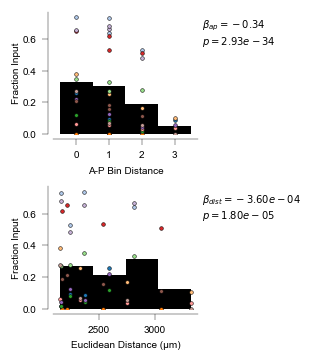

$\beta_{ap_corr} = -0.34864493047275646$
$p = 6.52e-31$


In [80]:
df = distances_df_indiv_mice.copy()
font_size = gen_parameters['font_size']
df["n_input"]   = (df["frac_input"] * df["total_neurons_in_bin"]).round().astype(int)
df["n_failure"] = df["total_neurons_in_bin"] - df["n_input"]
df["mouse_ac_bin"] = df["mouse"].astype(str) + "_bin" + df["ac_bin"].astype(str)
dummies = pd.get_dummies(df["mouse_ac_bin"], drop_first=True)
#df["ap_center"] = df["ap_offset"]+0.5 # put the scatter pts in the center of each barplot 
endog = df[["n_input", "n_failure"]]
groups = df["mouse_ac_bin"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(groups)))

X1    = pd.concat([sm.add_constant(df["ap_offset"]), dummies], axis=1)
res1  = sm.GLM(endog, X1, family=sm.families.Binomial()).fit()
X2    = pd.concat([sm.add_constant(df["dist"]), dummies], axis=1)
res2  = sm.GLM(endog, X2, family=sm.families.Binomial()).fit()
mean_dist = df["dist"].mean()
X3    = pd.concat([sm.add_constant(df[["ap_offset", "dist"]]), dummies], axis=1)
res3  = sm.GLM(endog, X3, family=sm.families.Binomial()).fit()
print(res1.summary())
print(res2.summary())
print(res3.summary())

groups = df["mouse_ac_bin"].unique()
colors = plt.cm.tab20(np.arange(len(groups)))

n_bins_ap = n_ac_bins
ap_bins = pd.cut(df["ap_offset"], bins=n_bins_ap)
mean_ap = (
    df.assign(ap_bin=ap_bins)
      .groupby("ap_bin")["frac_input"]
      .mean()
      .reset_index()
)

n_bins_dist = n_ac_bins
dist_bins = pd.cut(df["dist"], bins=n_bins_dist)
mean_dist = (
    df.assign(dist_bin=dist_bins)
      .groupby("dist_bin")["frac_input"]
      .mean()
      .reset_index()
)
mean_dist["left"]  = mean_dist["dist_bin"].apply(lambda iv: iv.left)
mean_dist["width"] = mean_dist["dist_bin"].apply(lambda iv: iv.right - iv.left)

fig, axes = plt.subplots(2, 1, figsize=(2.6, 3), sharey=True, dpi=120)
fig.subplots_adjust(right=0.75)
mean_ap = (
    df.groupby("ap_offset")["frac_input"]
      .mean()
      .reset_index()
)
ax = axes[0]
what_plot = ax.bar(mean_ap["ap_offset"],
       mean_ap["frac_input"],
       width=1,
       align="center",
       color="black",
       alpha=1,
       zorder=0)

for col, lbl in zip(colors, groups):
    sub = df[df["mouse_ac_bin"] == lbl]
    ax.scatter(sub["ap_offset"], sub["frac_input"],
               color=col, edgecolor="black", s=5, linewidths=0.3, alpha=1, zorder=1)
ax.tick_params(axis='both', which='major', labelsize=font_size)
# ax.set_xlabel("A-P Bin Distance", fontsize=font_size)
# ax.set_ylabel("Fraction Input", fontsize=font_size)
x_label = "A-P Bin Distance"
y_label = "Fraction Input"
ax.margins(x=0.05) 
coef_ap = res1.params["ap_offset"]
p_ap    = res1.pvalues["ap_offset"]
ax.text(1.03, 0.95,
        f"$\\beta_{{ap}} = {coef_ap:.2f}$\n$p = {p_ap:.2e}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=font_size,)
ff.myPlotSettings_splitAxis(fig=what_plot, ax=ax, ytitle= y_label, xtitle=x_label, title='', mySize =gen_parameters['font_size'])
ax.set_xticks([0, 1, 2, 3])
ax = axes[1]
what_plot = ax.bar(mean_dist["left"], mean_dist["frac_input"], width=mean_dist["width"],
       align="edge", color="black", alpha=1, zorder=0)
for col, lbl in zip(colors, groups):
    sub = df[df["mouse_ac_bin"] == lbl]
    ax.scatter(sub["dist"], sub["frac_input"],
               color=col, edgecolor="black", s=5, linewidths=0.3, alpha=1, zorder=1)
ax.margins(x=0.05) 
#ax.set_title("Effect of Distance")
x_label= "Euclidean Distance (µm)"

#ax.set_xlim(df["dist"].min(), df["dist"].max())
coef_dist = res2.params["dist"]
p_dist    = res2.pvalues["dist"]
ax.text(1.03, 0.95,
        f"$\\beta_{{dist}} = {coef_dist:.2e}$\n$p = {p_dist:.2e}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=font_size,)
ax.tick_params(axis='both', which='major', labelsize=font_size)

coef_ap_corrected = res3.params["ap_offset"]
p_ap_corrected    = res3.pvalues["ap_offset"]
ff.myPlotSettings_splitAxis(fig=what_plot, ax=ax, ytitle= y_label, xtitle=x_label, title='', mySize =gen_parameters['font_size'])
plt.tight_layout()
plt.show()
# plt.xlim(left=0)
# plt.ylim(bottom=0)
#plt.tight_layout()

fig.savefig(f"{saving_path}/supplementary/fig_4_AP_vs_VISAP_vs_euclidean.svg", format="svg")
print(f"$\\beta_{{ap_corr}} = {coef_ap_corrected}$\n$p = {p_ap_corrected:.2e}$")


In [100]:
area_AP_dict = {}
where_AP_vis = {}
cols = ['VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISal', 'VISam', 'VISa', 'VISpm', 'VISrl']
for col in cols:
    vals = []
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        mouse_bcs = combine_all_mice.loc[mouse_ind]
        proj_area = mouse_bcs[mouse_bcs[col]>0]
        indices = proj_area.index
        if len(proj_area)>0:
            AP_positions = AP_position_dict_list_combined.loc[indices]['AP_position']
            vals.append(np.mean(AP_positions))
    VIS_id =bg_atlas.structures[col]['id']
    rsp = mcc.get_reference_space()
    VIS_area_mask = rsp.make_structure_mask([VIS_id], direct_only=False)
    VIS_area_mask = VIS_area_mask* contra_mask
    centroid = np.argwhere(VIS_area_mask == 1).mean(axis=0)
    where_AP_vis[col] = max_y_vis - centroid[0]
    area_AP_dict[col] = vals

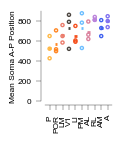

In [105]:
# HVA_colors_updated = {
#     'VISp': '#6E665E',
#     'VISpor': '#79B855',
#     'VISli': '#AAC255',
#     'VISpl': '#4C9E57',
#     'VISl': '#D6C759',
#     'VISal': '#C7A859',
#     'VISrl': '#F0BE7E',
#     'VISa': '#D78257',
#     'VISam': '#C2543C',
#     'VISpm': '#D7716C'
# }
convert_dict = ff.get_convert_dict()
font_size = gen_parameters['font_size']

# Example: Suppose 'where_AP_vis' has the same keys as 'area_AP_dict'.
# Each key in 'where_AP_vis' might be a single float or an iterable.
# For demonstration, let's say each entry is a single float.
# You could do np.mean(...) if each entry is a list/array.

# 1) Sort keys based on value in 'where_AP_vis'
# If 'where_AP_vis[key]' is a single float:
keys_sorted = sorted(
    area_AP_dict.keys(),
    key=lambda k: where_AP_vis[k]  # or np.mean(where_AP_vis[k]) if it's a list
)

fig, ax = plt.subplots(figsize=(1.2, 1.4))

# 2) Plot in the new sorted order
for i, key in enumerate(keys_sorted):
    positions = area_AP_dict[key]
    values = [val*25 for val in positions]
    color = which_colour[key]#HVA_colors_updated.get(key, "black")
    
    # Scatter each point
    xvals = np.full(len(values), i)  # same x position for the group's points
    ax.scatter(
        xvals, values,
        marker='o',
        facecolors='none',
        edgecolors=color,
        s=5,
        label=key
    )
    
    # Draw a horizontal line at the mean
    mean_val = np.mean(values)
    ax.hlines(
        y=mean_val,
        xmin=i - 0.2,
        xmax=i + 0.2,
        colors=color,
        linewidth=2
    )

# 3) Convert x-tick labels to readable names in the same sorted order
converted_labels = [convert_dict.get(k, k) for k in keys_sorted]
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= '', xtitle='', title='', mySize =font_size)
ax.set_xticks(range(len(keys_sorted)))
ax.set_xticklabels(converted_labels, rotation=90, size=font_size)
ax.set_ylabel("Mean Soma A-P Position", size=font_size)
ax.set_ylim(bottom=0)
plt.tight_layout()
fig.savefig(f"{saving_path}/fig2_meanAP_pos_area.svg", format="svg")
plt.show()


Now plot individual areas

p value for VISam is 0.014
p value for VISrl is 1.8e-22
p value for VISpor is 4.2e-28
p value for VISpl is 4.2e-10


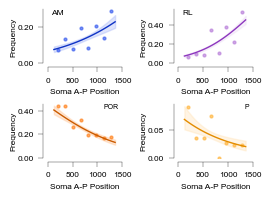

In [17]:
import statsmodels.formula.api as smf

area_dic= {}
for area in combine_all_mice.columns:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'proj_freq'])
    ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
        mouse_bcs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)
        for AP in ap_corr_mouse.unique():
            indices = ap_corr_mouse[ap_corr_mouse==AP]
            if len(indices)<5:
                continue
            else:
                freq = mouse_bcs.loc[indices.index][area].mean()
                new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP*25], "proj_freq": [freq]})
                area_df = pd.concat([area_df, new_row], ignore_index=True)
        area_dic[area] = area_df

logistic_reg_area_dict = {}
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
for mouse in mice:
    mouse_ind = which_mice[which_mice['mice']==mouse].index
    ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    mouse_bcs = combine_all_mice.loc[mouse_ind][visual_areas].astype(bool).astype(int).copy()
    for AP in ap_corr_mouse.unique():
        indices = ap_corr_mouse[ap_corr_mouse==AP]
        if len(indices)<5:
            continue
        else:
            logistic_reg_area_dict[AP] = mouse_bcs.loc[indices.index]
            logistic_reg_area_dict[AP]['mouse'] = mouse
            logistic_reg_area_dict[AP]['AP_position'] = AP*25

combined_df = pd.concat(logistic_reg_area_dict.values(), axis=0, ignore_index=False)

results_popuplation_dict = {}
df = combined_df.melt(id_vars=['mouse', 'AP_position'], var_name='Area', value_name='Projection')
pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
for area in visual_areas:
    df_area = df[df['Area'] == area]
    model = smf.logit('Projection ~ AP_position + mouse', data=df_area).fit(disp=False)
    results = model.summary2().tables[1]
    results_popuplation_dict[area] = smf.logit('Projection ~ AP_position', data=df_area).fit(disp=False)
    pval_df.loc[area, 'p_value'] = results.loc['AP_position', 'P>|z|']
    pval_df.loc[area, 'OR'] = np.exp(results.loc['AP_position', 'Coef.'])

pval_df['p_value_corrected'] = pval_df['p_value']*len(visual_areas)
HVA_colors_updated = {
    'VISp': '#6E665E',
    'VISpor': '#79B855',
    'VISli': '#AAC255',
    'VISpl': '#4C9E57',
    'VISl': '#D6C759',
    'VISal': '#C7A859',
    'VISrl': '#F0BE7E',
    'VISa': '#D78257',
    'VISam': '#C2543C',
    'VISpm': '#D7716C'
}
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from matplotlib.ticker import FormatStrFormatter

def adjust_color(color, amount=1.0):
    try:
        c = mc.cnames[color]
    except:
        c = color
    r, g, b = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(min(l * amount, 1.0), 0.0)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
num_bins = 8

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2.7, 2)) 
axes = axes.flatten()

for idx, (ax, area) in enumerate(zip(axes, areas_to_plot)):
    model = results_popuplation_dict[area]
    main_color = HVA_colors_updated.get(area, 'black')
    fit_color = adjust_color(main_color, 0.7)
    ci_color  = adjust_color(main_color, 1.3)

    df_area = df[df['Area'] == area].copy()
    ap_vals = df_area['AP_position'].values
    proj_vals = df_area['Projection'].values
    bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_proportions = []
    for i in range(num_bins):
        in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
        if np.sum(in_bin) > 0:
            bin_proportions.append(proj_vals[in_bin].mean())
        else:
            bin_proportions.append(np.nan)
    
    valid = ~np.isnan(bin_proportions)
    ax.plot(bin_centers[valid],
            np.array(bin_proportions)[valid],
            'o',
            label='Binned data',
            color=main_color, markersize=2,
            alpha=0.7)

    ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)
    new_data = pd.DataFrame({'AP_position': ap_grid})
    
    pred = model.get_prediction(new_data)
    pred_df = pred.summary_frame(alpha=0.05)
    yhat  = pred_df['predicted']
    lower = pred_df['ci_lower']
    upper = pred_df['ci_upper']
    
    ax.plot(ap_grid, yhat, '-', color=fit_color, linewidth=1)
    ax.fill_between(ap_grid, lower, upper, color=ci_color, alpha=0.3)

    ff.myPlotSettings_splitAxis(
        fig=fig, ax=ax,
        ytitle='Frequency',
        xtitle="Soma A-P Position",
        title="",
        axisColor='k',
        mySize=font_size
    )
    
    
    p_corrected = pval_df.loc[area, 'p_value_corrected']
    print (f'p value for {area} is {p_corrected:.2g}')
    if idx < 2:
        ax.text(0.05, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=font_size, color='black')
    else:
        ax.text(0.95, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=5, color='black')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xticks([0, 500, 1000, 1500])
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")


Now check medial-lateral position differences

In [256]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(np.logical_and(VIS_mask, contra_mask))
indices_AUDp_contra = np.argwhere(np.logical_and(AUDp_mask, contra_mask))
min_x = indices_AUDp_contra[:, 2].min() 
max_x = indices_AUDp_contra[:, 2].max() 
max_x_vis = np.max(indices_VIS[:, 2])
min_x_vis = np.min(indices_VIS[:, 2])
#select anterior and posterior parts of A1
#max_x = np.max(indices_AUDp[:, 2])
#min_x = np.min(indices_AUDp[:, 2])
# AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
#lets get the coordinates for the centre of A1
A1_masked = contra_mask * AUDp_mask
A1_centroid_coords = np.argwhere(A1_masked == 1).mean(axis=0)

#now lets load the barcodes
proj_path = pathlib.Path(gen_parameters['proj_path'])
mice = gen_parameters['MICE']
mouse_dict_ML_source = {}
mouse_dict_ML_VC = {}
mouse_barcodes_by_source = {}
mouse_vis_main_dict = {}
mouse_vis_coord = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    ML_position_dict = {}
    AP_position_vis_dict = {}
    vis_main_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    barcodes_no_soma = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded.pkl")
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    all_VIS_ROI = np.unique(ROI_3D *  VIS_mask * contra_mask)
    vis_coord = {}
    #lets make sure we keep the same criteria of removing VIS rois where more than 10% is in AUDp
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes_no_soma.columns,
        lcm_directory=lcm_directory,
        area_threshold=0.1,
    )
    visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    frac = areas_only_grouped.div(areas_only_grouped.sum(axis=1), axis=0)
    frac_filtered = frac.loc[(frac[visual_areas].gt(0).any(axis=1)) & (frac['AUDp'] > 0.1)].index
    all_VIS_ROI = [sample for sample in all_VIS_ROI if sample != 0 and sample in barcodes_no_soma.columns and sample not in frac_filtered and areas_only_grouped[visual_areas].loc[sample].sum()>0]

    for sample in all_VIS_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        vis_coord[sample] = centroid
        AP_position_vis_dict[sample] = centroid[2] - min_x_vis #max_x_vis - centroid[2]  #centroid[0]-min_y_vis
        vis_main_dict[sample] = areas_only_grouped[visual_areas].loc[sample].idxmax()
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        ML_position_dict[sample] =  centroid[2] - min_x  #max_x -centroid[2]  #-min_y#AP_midpoint_A1
    mouse_dict_ML_source[mouse]=ML_position_dict
    mouse_dict_ML_VC[mouse] = AP_position_vis_dict
    mouse_vis_main_dict[mouse] = vis_main_dict
    mouse_vis_coord[mouse] = vis_coord

def get_ML_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found
#make a dataframe with mean AP_pos of sample, mouse and AP_soma
ML_soma_VC_sample = pd.DataFrame(columns=['Mouse', 'mean_ML_soma', 'ML_Vis', 'VC_majority', 'dist_3d', 'sample'])
ML_soma_VC_sample_all = pd.DataFrame(columns=['Mouse', 'actual_ML_soma', 'ML_Vis'])
barcodes_dict = {}

ML_position_dict_list = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"{proj_path}/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    barcodes= fpf.add_prefix_to_index(barcodes, mouse)
    soma = pd.DataFrame(barcodes.idxmax(axis=1))
    soma['ML_position'] = soma.apply(lambda row: get_ML_position(row, mouse_dict_ML_source[mouse]), axis=1)
    #soma['uncorrected_AP']= soma.apply(lambda row: get_ML_position(row, mouse_dict_AP_source_uncorrected[mouse]), axis=1)
    for sample in mouse_dict_ML_VC[mouse].keys():
        indices_for_sample = barcodes[barcodes[sample]>0].index
        if len(indices_for_sample)>2:
            mean_ML= np.mean(soma.loc[indices_for_sample]['ML_position'])
            uncorrected_meanML = mean_ML + min_x #back to non-normalised
            A1_coord_updated = [A1_centroid_coords[0], A1_centroid_coords[1], uncorrected_meanML]
            dist_3d = np.linalg.norm(np.array(A1_coord_updated) - np.array(mouse_vis_coord[mouse][sample])) * 25
            new_row= pd.DataFrame({'Mouse':[mouse], 'mean_ML_soma':[(mean_ML)*25], 'ML_Vis':[mouse_dict_ML_VC[mouse][sample]*25], 'VC_majority': [mouse_vis_main_dict[mouse][sample]], 'dist_3d': [dist_3d], 'sample': [sample]})
            bl = pd.DataFrame()
            bl['ML_postion'] = soma.loc[indices_for_sample]['ML_position']
            bl['Mouse'] = mouse
            bl['actual_ML_soma'] = mouse_dict_ML_VC[mouse][sample]
            ML_soma_VC_sample = pd.concat([ML_soma_VC_sample, new_row])
            ML_soma_VC_sample_all = pd.concat([ML_soma_VC_sample_all, bl])
    #barcodes_dict[mouse] = barcodes_assigned_area.drop(columns=['AUDp'])
    #soma_filtered = soma.loc[combined_mice_dict[mouse]['homog_across_cubelet'].index]
    ML_position_dict_list[mouse] = soma#soma_filtered
    # mouse_euclidean_dist[mouse] = euclidean_dist
# ML_position_dict_list_combined= pd.concat([ML_position_dict_list['FIAA45.6a'], ML_position_dict_list['FIAA45.6d'], ML_position_dict_list['FIAA55.4d']])

ML_position_dict_list_combined = pd.concat([
    ML_position_dict_list[k] for k in mice
])
ML_soma_VC_sample['converted'] = ML_soma_VC_sample['VC_majority'].map(convert_dict)
rho, pval = pearsonr(ML_soma_VC_sample['ML_Vis'], ML_soma_VC_sample['mean_ML_soma'])


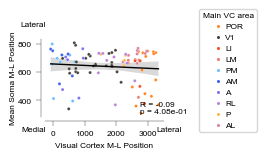

In [286]:
font_size = gen_parameters['font_size']
fig, ax = plt.subplots(figsize=(3, 1.5)) 
sb.regplot(
    x='ML_Vis',
    y='mean_ML_soma',
    data=ML_soma_VC_sample, color='black', scatter=False,
    ci=95, scatter_kws={'s':5}, line_kws={'linewidth':1}
)
scatter = sb.scatterplot(
    x='ML_Vis', 
    y='mean_ML_soma', 
    data=ML_soma_VC_sample, 
    hue='converted', 
    palette=which_colour_other,  
    s=5, legend=True,      
)

handles, labels = scatter.get_legend_handles_labels()

ax.legend(
    handles=handles, 
    labels=labels, 
    title="Main VC area", 
    bbox_to_anchor=(1.3, -0.2),  
    loc='lower left', 
    borderaxespad=0, 
    fontsize=font_size, 
    handlelength=1,
    handletextpad=0.4,
    markerscale=0.2)
leg = ax.get_legend()        # the auto legend
leg.set_title("Main VC area", prop={'size': font_size})
for txt in leg.get_texts():
    txt.set_fontsize(font_size)
plt.text(
    0.8, 0.2,
    f"R = {rho:.2f}\np = {pval:.2e}",
    ha='left',
    va='top',
    transform=plt.gca().transAxes,
    fontsize=font_size,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0)
)
xlabel = 'Visual Cortex M-L Position'
ylabel = 'Mean Soma M-L Position'
plt.text(1.15, -0.2, 'Lateral', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=font_size)
plt.text(-0.1, 1.15, 'Lateral', ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=font_size)
plt.text(-0.1, -0.2, 'Medial', transform=plt.gca().transAxes, fontsize=font_size, va='bottom', ha='center')
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= ylabel, xtitle=xlabel, title='', mySize =font_size)
plt.tight_layout()
fig.savefig(f"{saving_path}/supplementary/fig_s4_ML_vs_VISML.svg", format="svg")
plt.show()


In [271]:
font_size

8

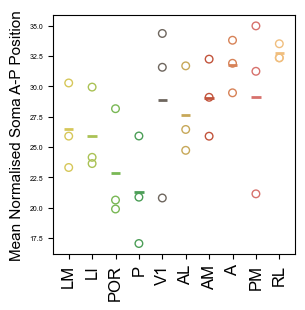

In [48]:
# HVA_colors_updated = {
#     'VISp': '#6E665E',
#     'VISpor': '#79B855',
#     'VISli': '#AAC255',
#     'VISpl': '#4C9E57',
#     'VISl': '#D6C759',
#     'VISal': '#C7A859',
#     'VISrl': '#F0BE7E',
#     'VISa': '#D78257',
#     'VISam': '#C2543C',
#     'VISpm': '#D7716C'
# }
# convert_dict = {
#     "VISl": "LM",
#     "VISrl": "RL",
#     "VISal": "AL",
#     "VISa": "A",
#     "VISp": "V1",
#     "VISpor": "POR",
#     "VISli": "LI",
#     "VISpl": "P",
#     "VISpm": "PM",
#     "VISam": "AM"
# }

# fig, ax = plt.subplots(figsize=(3, 3))

# keys = list(area_AP_dict.keys())

# for i, key in enumerate(keys):
#     values = area_AP_dict[key]
#     # Pull color from the dictionary; default to black if key not found
#     color = HVA_colors_updated.get(key, "black")
    
#     # 1) Plot individual points as a scatter
#     xvals = np.full(len(values), i)  # same x position for the group's points
#     ax.scatter(xvals, values,marker='o',
#     facecolors='none',    
#     edgecolors=color, s=30, label=key, color=color)
    
#     # 2) Draw a horizontal line at the mean in the same color
#     mean_val = np.mean(values)
#     ax.hlines(y=mean_val, xmin=i - 0.2, xmax=i + 0.2, 
#               colors=color, linewidth=2)

# converted_labels = [convert_dict.get(k, k) for k in keys]
# ax.set_xticks(range(len(keys)))
# ax.set_xticklabels(converted_labels, rotation=90, size=12)

# ax.set_ylabel("Mean Normalised Soma A-P Position", size=11)


# plt.tight_layout()
# plt.show()

p value for VISam is 0.014
p value for VISrl is 1.8e-22
p value for VISpor is 4.2e-28
p value for VISpl is 4.2e-10


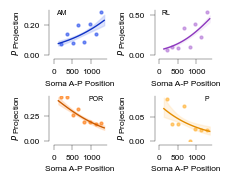

In [10]:
import statsmodels.formula.api as smf

area_dic= {}
for area in combine_all_mice.columns:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'proj_freq'])
    ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
        mouse_bcs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)
        for AP in ap_corr_mouse.unique():
            indices = ap_corr_mouse[ap_corr_mouse==AP]
            if len(indices)<5:
                continue
            else:
                freq = mouse_bcs.loc[indices.index][area].mean()
                new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP*25], "proj_freq": [freq]})
                area_df = pd.concat([area_df, new_row], ignore_index=True)
        area_dic[area] = area_df

logistic_reg_area_dict = {}
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
for mouse in mice:
    mouse_ind = which_mice[which_mice['mice']==mouse].index
    ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
    mouse_bcs = combine_all_mice.loc[mouse_ind][visual_areas].astype(bool).astype(int).copy()
    for AP in ap_corr_mouse.unique():
        indices = ap_corr_mouse[ap_corr_mouse==AP]
        if len(indices)<5:
            continue
        else:
            logistic_reg_area_dict[AP] = mouse_bcs.loc[indices.index]
            logistic_reg_area_dict[AP]['mouse'] = mouse
            logistic_reg_area_dict[AP]['AP_position'] = AP*25

combined_df = pd.concat(logistic_reg_area_dict.values(), axis=0, ignore_index=False)

results_popuplation_dict = {}
df = combined_df.melt(id_vars=['mouse', 'AP_position'], var_name='Area', value_name='Projection')
pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
for area in visual_areas:
    df_area = df[df['Area'] == area]
    model = smf.logit('Projection ~ AP_position + mouse', data=df_area).fit(disp=False)
    results = model.summary2().tables[1]
    results_popuplation_dict[area] = smf.logit('Projection ~ AP_position', data=df_area).fit(disp=False)
    pval_df.loc[area, 'p_value'] = results.loc['AP_position', 'P>|z|']
    pval_df.loc[area, 'OR'] = np.exp(results.loc['AP_position', 'Coef.'])

pval_df['p_value_corrected'] = pval_df['p_value']*len(visual_areas)
HVA_colors_updated = {
    'VISp': '#6E665E',
    'VISpor': '#79B855',
    'VISli': '#AAC255',
    'VISpl': '#4C9E57',
    'VISl': '#D6C759',
    'VISal': '#C7A859',
    'VISrl': '#F0BE7E',
    'VISa': '#D78257',
    'VISam': '#C2543C',
    'VISpm': '#D7716C'
}
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from matplotlib.ticker import FormatStrFormatter

def adjust_color(color, amount=1.0):
    try:
        c = mc.cnames[color]
    except:
        c = color
    r, g, b = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(min(l * amount, 1.0), 0.0)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
num_bins = 8

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2.2, 1.8)) 
axes = axes.flatten()

for idx, (ax, area) in enumerate(zip(axes, areas_to_plot)):
    model = results_popuplation_dict[area]
    main_color = HVA_colors_updated.get(area, 'black')
    fit_color = adjust_color(main_color, 0.7)
    ci_color  = adjust_color(main_color, 1.3)

    df_area = df[df['Area'] == area].copy()
    ap_vals = df_area['AP_position'].values
    proj_vals = df_area['Projection'].values
    bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_proportions = []
    for i in range(num_bins):
        in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
        if np.sum(in_bin) > 0:
            bin_proportions.append(proj_vals[in_bin].mean())
        else:
            bin_proportions.append(np.nan)
    
    valid = ~np.isnan(bin_proportions)
    ax.plot(bin_centers[valid],
            np.array(bin_proportions)[valid],
            'o',
            label='Binned data',
            color=main_color, markersize=2,
            alpha=0.7)

    ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)
    new_data = pd.DataFrame({'AP_position': ap_grid})
    
    pred = model.get_prediction(new_data)
    pred_df = pred.summary_frame(alpha=0.05)
    yhat  = pred_df['predicted']
    lower = pred_df['ci_lower']
    upper = pred_df['ci_upper']
    
    ax.plot(ap_grid, yhat, '-', color=fit_color, linewidth=1)
    ax.fill_between(ap_grid, lower, upper, color=ci_color, alpha=0.3)

    ff.myPlotSettings_splitAxis(
        fig=fig, ax=ax,
        ytitle=r"$\it{P}$ Projection",
        xtitle="Soma A-P Position",
        title="",
        axisColor='k',
        mySize=6
    )
    
    
    p_corrected = pval_df.loc[area, 'p_value_corrected']
    print (f'p value for {area} is {p_corrected:.2g}')
    if idx < 2:
        ax.text(0.05, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=5, color='black')
    else:
        ax.text(0.95, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=5, color='black')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xticks([0, 500, 1000])
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")


In [17]:
# logistic_reg_area_dict = {}
# visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
# for mouse in mice:
#     mouse_ind = which_mice[which_mice['mice']==mouse].index
#     ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
#     mouse_bcs = combine_all_mice.loc[mouse_ind][visual_areas].astype(bool).astype(int).copy()
#     for AP in ap_corr_mouse.unique():
#         indices = ap_corr_mouse[ap_corr_mouse==AP]
#         if len(indices)<5:
#             continue
#         else:
#             logistic_reg_area_dict[AP] = mouse_bcs.loc[indices.index]
#             logistic_reg_area_dict[AP]['mouse'] = mouse
#             logistic_reg_area_dict[AP]['AP_position'] = AP*25

# combined_df = pd.concat(logistic_reg_area_dict.values(), axis=0, ignore_index=False)


In [18]:
# results_popuplation_dict = {}
# df = combined_df.melt(id_vars=['mouse', 'AP_position'], var_name='Area', value_name='Projection')
# pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
# for area in visual_areas:
#     df_area = df[df['Area'] == area]
#     model = smf.logit('Projection ~ AP_position + mouse', data=df_area).fit(disp=False)
#     results = model.summary2().tables[1]
#     results_popuplation_dict[area] = smf.logit('Projection ~ AP_position', data=df_area).fit(disp=False)
#     pval_df.loc[area, 'p_value'] = results.loc['AP_position', 'P>|z|']
#     pval_df.loc[area, 'OR'] = np.exp(results.loc['AP_position', 'Coef.'])

# pval_df['p_value_corrected'] = pval_df['p_value']*len(visual_areas)



In [19]:
# HVA_colors_updated = {
#     'VISp': '#6E665E',
#     'VISpor': '#79B855',
#     'VISli': '#AAC255',
#     'VISpl': '#4C9E57',
#     'VISl': '#D6C759',
#     'VISal': '#C7A859',
#     'VISrl': '#F0BE7E',
#     'VISa': '#D78257',
#     'VISam': '#C2543C',
#     'VISpm': '#D7716C'
# }
# convert_dict = {
#     "VISl": "LM",
#     "VISrl": "RL",
#     "VISal": "AL",
#     "VISa": "A",
#     "VISp": "V1",
#     "VISpor": "POR",
#     "VISli": "LI",
#     "VISpl": "P",
#     "VISpm": "PM",
#     "VISam": "AM"
# }

In [72]:


# # Suppose you've already run your logistic regressions and have:
# # results_dict[area] = fitted model
# # df is your long-form DataFrame with columns: ['mouse','AP_position','Area','Projection']

# # Choose four areas to plot
# areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']  # Example subset of 4 areas

# # Number of bins for raw-data plotting
# num_bins = 8

# # Create a 2×2 figure
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(1, 4))
# axes = axes.flatten()  # Flatten to iterate easily over 4 axes

# for ax, area in zip(axes, areas_to_plot):
#     # Extract the logistic regression model for this area
#     model = results_popuplation_dict[area]
#     main_color = HVA_colors_updated.get(area, 'black')
#     # Subset the data for this area
#     df_area = df[df['Area'] == area].copy()

#     # ------------------------------------------------------------
#     # 1) Plot the raw data as binned proportions
#     # ------------------------------------------------------------
#     # We'll bin AP_position into intervals and compute the proportion of projecting neurons
#     ap_vals = df_area['AP_position'].values
#     proj_vals = df_area['Projection'].values

#     # Define bin edges
#     bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     bin_proportions = []
#     for i in range(num_bins):
#         in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
#         if np.sum(in_bin) > 0:
#             bin_proportions.append(proj_vals[in_bin].mean())  # fraction projecting
#         else:
#             bin_proportions.append(np.nan)

#     # Plot the binned proportions (exclude bins with no data)
#     valid = ~np.isnan(bin_proportions)
#     ax.plot(bin_centers[valid],
#             np.array(bin_proportions)[valid],
#             'o',
#             label='Binned data (raw)', color=main_color,
#             alpha=0.7)

#     # ------------------------------------------------------------
#     # 2) Plot the fitted logistic curve (+ confidence intervals)
#     # ------------------------------------------------------------
#     # Create a fine grid of AP positions
#     ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)

#     # Choose one mouse as reference for prediction (since "mouse" is in the model)
#     reference_mouse = df_area['mouse'].unique()[0]
#     new_data = pd.DataFrame({
#         'AP_position': ap_grid,
#         'mouse': reference_mouse  # or choose another
#     })

#     # Use model.get_prediction(...) to get predicted means + confidence intervals
#     pred = model.get_prediction(new_data)
#     # Convert to a DataFrame
#     pred_df = pred.summary_frame(alpha=0.05)  # 95% CI => alpha=0.05

#     # Depending on statsmodels version, columns may be named slightly differently:
#     # Check if 'mean_ci_lower'/'mean_ci_upper' or 'obs_ci_lower'/'obs_ci_upper'
#     yhat = pred_df['predicted']
#     lower = pred_df['ci_lower']
#     upper = pred_df['ci_upper']

#     # Plot the fitted logistic curve
#     ax.plot(ap_grid, yhat, '-', label='Logistic fit')

#     # Fill the CI region
#     ax.fill_between(ap_grid, lower, upper, alpha=0.3, label='95% CI')

#     # ------------------------------------------------------------
#     # 3) Aesthetics and labels
#     # ------------------------------------------------------------
#     ax.set_title(f"Logistic Regression: {area}")
#     ax.set_xlabel("AP Position")
#     ax.set_ylabel("Probability of Projection")
#     #ax.set_ylim(-0.05, 1.05)  # just a little margin
#     ax.legend()

# # If fewer than 4 areas, any remaining axes won’t be used; hide them.
# if len(areas_to_plot) < 4:
#     for unused_ax in axes[len(areas_to_plot):]:
#         unused_ax.set_visible(False)

# plt.tight_layout()
# plt.show()


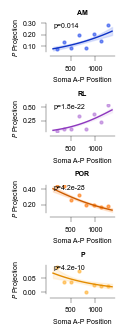

In [12]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mc
# import colorsys
# from matplotlib.ticker import FormatStrFormatter

# def adjust_color(color, amount=1.0):
#     """
#     Adjust the brightness of a given color.
#     amount < 1.0 => darker
#     amount > 1.0 => lighter
#     """
#     try:
#         c = mc.cnames[color]  # if color is a named color like 'red'
#     except:
#         c = color            # else assume it's a hex or RGB tuple
#     r, g, b = mc.to_rgb(c)
#     h, l, s = colorsys.rgb_to_hls(r, g, b)
#     # Scale the lightness
#     l = max(min(l * amount, 1.0), 0.0)
#     r, g, b = colorsys.hls_to_rgb(h, l, s)
#     return (r, g, b)

# HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
# areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
# num_bins = 8

# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(1.2, 3.3))
# axes = axes.flatten()

# for ax, area in zip(axes, areas_to_plot):
#     model = results_popuplation_dict[area]  # your fitted logistic model for this area
#     main_color = HVA_colors_updated.get(area, 'black')
#     fit_color = adjust_color(main_color, 0.7)  # darker line
#     ci_color  = adjust_color(main_color, 1.3)  # lighter fill
#     df_area = df[df['Area'] == area].copy()
#     ap_vals = df_area['AP_position'].values
#     proj_vals = df_area['Projection'].values
#     bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     bin_proportions = []
#     for i in range(num_bins):
#         in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
#         if np.sum(in_bin) > 0:
#             bin_proportions.append(proj_vals[in_bin].mean())
#         else:
#             bin_proportions.append(np.nan)
    
#     valid = ~np.isnan(bin_proportions)
#     subplot = ax.plot(bin_centers[valid],
#             np.array(bin_proportions)[valid],
#             'o',
#             label='Binned data',
#             color=main_color, markersize=2,
#             alpha=0.7)
    
#     # 2) Logistic curve + confidence interval
#     ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)
#     #reference_mouse = df_area['mouse'].unique()[0]
#     new_data = pd.DataFrame({
#         'AP_position': ap_grid
#     })
    
#     pred = model.get_prediction(new_data)
#     pred_df = pred.summary_frame(alpha=0.05)  # 95% CI
#     yhat  = pred_df['predicted']
#     lower = pred_df['ci_lower']
#     upper = pred_df['ci_upper']
    
#     ax.plot(ap_grid, yhat, '-',
#             label='Logistic fit',
#             color=fit_color,
#             linewidth=1)
#     ax.fill_between(ap_grid, lower, upper,
#                     color=ci_color,
#                     alpha=0.3,
#                     label='95% CI')
#     ff.myPlotSettings_splitAxis(fig=subplot,ax=ax,ytitle= r"$\it{P}$ Projection",xtitle="Soma A-P Position",title=convert_dict[area],axisColor = 'k', mySize=5)
#     p_corrected = pval_df.loc[area, 'p_value_corrected']
#     ax.text(
#         0.05, 1,  
#         (f"p={p_corrected:.2g}"), 
#         transform=ax.transAxes,
#         ha='left', va='top',
#         fontsize=5, color='black'
#     )
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.subplots_adjust(hspace=2)
# plt.tight_layout()
# plt.show()
# #fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")


p value for VISam is 0.014
p value for VISrl is 1.8e-22
p value for VISpor is 4.2e-28
p value for VISpl is 4.2e-10


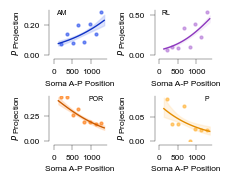

NameError: name 'saving_path' is not defined

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from matplotlib.ticker import FormatStrFormatter

def adjust_color(color, amount=1.0):
    try:
        c = mc.cnames[color]
    except:
        c = color
    r, g, b = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(min(l * amount, 1.0), 0.0)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
num_bins = 8

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2.2, 1.8)) 
axes = axes.flatten()

for idx, (ax, area) in enumerate(zip(axes, areas_to_plot)):
    model = results_popuplation_dict[area]
    main_color = HVA_colors_updated.get(area, 'black')
    fit_color = adjust_color(main_color, 0.7)
    ci_color  = adjust_color(main_color, 1.3)

    df_area = df[df['Area'] == area].copy()
    ap_vals = df_area['AP_position'].values
    proj_vals = df_area['Projection'].values
    bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_proportions = []
    for i in range(num_bins):
        in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
        if np.sum(in_bin) > 0:
            bin_proportions.append(proj_vals[in_bin].mean())
        else:
            bin_proportions.append(np.nan)
    
    valid = ~np.isnan(bin_proportions)
    ax.plot(bin_centers[valid],
            np.array(bin_proportions)[valid],
            'o',
            label='Binned data',
            color=main_color, markersize=2,
            alpha=0.7)

    ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)
    new_data = pd.DataFrame({'AP_position': ap_grid})
    
    pred = model.get_prediction(new_data)
    pred_df = pred.summary_frame(alpha=0.05)
    yhat  = pred_df['predicted']
    lower = pred_df['ci_lower']
    upper = pred_df['ci_upper']
    
    ax.plot(ap_grid, yhat, '-', color=fit_color, linewidth=1)
    ax.fill_between(ap_grid, lower, upper, color=ci_color, alpha=0.3)

    ff.myPlotSettings_splitAxis(
        fig=fig, ax=ax,
        ytitle=r"$\it{P}$ Projection",
        xtitle="Soma A-P Position",
        title="",
        axisColor='k',
        mySize=6
    )
    
    
    p_corrected = pval_df.loc[area, 'p_value_corrected']
    print (f'p value for {area} is {p_corrected:.2g}')
    if idx < 2:
        ax.text(0.05, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=5, color='black')
    else:
        ax.text(0.95, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=5, color='black')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xticks([0, 500, 1000])
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")


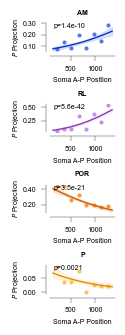

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FormatStrFormatter

# results_popuplation_dict = {}
# df = combined_df.melt(id_vars=['mouse', 'AP_position'], var_name='Area', value_name='Projection')
# pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
# for area in visual_areas:
#     df_area = df[df['Area'] == area]
#     model = smf.logit('Projection ~ AP_position', data=df_area).fit(disp=False)
#     results = model.summary2().tables[1]
#     results_popuplation_dict[area] = smf.logit('Projection ~ AP_position', data=df_area).fit(disp=False)

# pval_df['p_value_corrected'] = pval_df['p_value']*len(visual_areas)

# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(1.2, 3.3))
# axes = axes.flatten()
# num_bins = 8
# areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']

# for ax, area in zip(axes, areas_to_plot):
#     model = results_popuplation_dict[area]
#     main_color = HVA_colors_updated.get(area, 'black')
#     fit_color = adjust_color(main_color, 0.7)
#     ci_color  = adjust_color(main_color, 1.3)
#     df_area = df[df['Area'] == area].copy()
#     ap_vals = df_area['AP_position'].values
#     proj_vals = df_area['Projection'].values
    
#     # 1) Plot binned data points (population level)
#     bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     bin_proportions = []
    
#     for i in range(num_bins):
#         in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
#         if np.sum(in_bin) > 0:
#             bin_proportions.append(proj_vals[in_bin].mean()) #for each bin, get the projection frequency
#         else:
#             bin_proportions.append(np.nan)
    
#     valid = ~np.isnan(bin_proportions)
#     ax.plot(
#         bin_centers[valid],
#         np.array(bin_proportions)[valid],
#         'o',
#         label='Binned data',
#         color=main_color,
#         markersize=2,
#         alpha=0.8
#     )
    
#     # 2) Plot logistic regression fit (full model)
#     ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 200)
#     new_data = pd.DataFrame({'AP_position': ap_grid})
    
#     pred = model.get_prediction(new_data)
#     pred_df = pred.summary_frame(alpha=0.05)
    
#     yhat = pred_df['predicted']
#     lower = pred_df['ci_lower']
#     upper = pred_df['ci_upper']
    
#     ax.plot(ap_grid, yhat, '-', color=fit_color, linewidth=1)
#     ax.fill_between(ap_grid, lower, upper, color=ci_color, alpha=0.3)
    
#     # 3) Styling
#     ff.myPlotSettings_splitAxis(
#         fig=fig,
#         ax=ax,
#         ytitle=r"$\it{P}$ Projection",
#         xtitle="Soma A-P Position",
#         title=convert_dict[area],
#         axisColor='k',
#         mySize=5
#     )
    
#     p_corrected = pval_df.loc[area, 'p_value_corrected']
#     ax.text(
#         0.05, 1,
#         f"p={p_corrected:.2g}",
#         transform=ax.transAxes,
#         ha='left', va='top',
#         fontsize=5,
#         color='black'
#     )
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# plt.subplots_adjust(hspace=2)
# plt.tight_layout()
# plt.show()


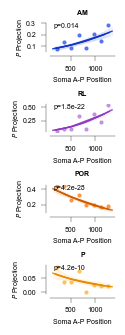

In [26]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
# num_bins = 8

# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(1.2, 3.3))
# axes = axes.flatten()

# for ax, area in zip(axes, areas_to_plot):
#     model = results_popuplation_dict[area]  # your fitted logistic model
#     main_color = HVA_colors_updated.get(area, 'black')
#     fit_color = adjust_color(main_color, 0.7)  # darker line
#     ci_color  = adjust_color(main_color, 1.3)  # lighter fill

#     # -------------------------------------------------------
#     # 1) Population-level binned data (ALL mice combined)
#     # -------------------------------------------------------
#     df_area = df[df['Area'] == area].copy()
#     ap_vals = df_area['AP_position'].values
#     proj_vals = df_area['Projection'].values
    
#     bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     bin_proportions = []
#     for i in range(num_bins):
#         in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
#         if np.sum(in_bin) > 0:
#             bin_proportions.append(proj_vals[in_bin].mean())
#         else:
#             bin_proportions.append(np.nan)
#     valid = ~np.isnan(bin_proportions)
#     ax.plot(
#         bin_centers[valid],
#         np.array(bin_proportions)[valid],
#         'o',
#         label='Binned data (population)',
#         color=main_color,
#         markersize=2,
#         alpha=0.8
#     )
    
#     # -------------------------------------------------------
#     # 2) Plot each mouse's fitted logistic curve
#     #    using the mouse's REAL AP_position values
#     # -------------------------------------------------------
#     all_mice = df_area['mouse'].unique()
#     for m in all_mice:
#         df_m = df_area[df_area['mouse'] == m].copy()
#         if df_m.empty:
#             continue  # just in case

#         # Sort by AP_position to get a left-to-right line
#         df_m.sort_values('AP_position', inplace=True)

#         # Use get_prediction on the real AP positions
#         pred = model.get_prediction(df_m)
#         pred_df = pred.summary_frame(alpha=0.05)  # 95% CI

#         # The predicted probabilities and CI for each row
#         yhat  = pred_df['predicted']
#         lower = pred_df['ci_lower']
#         upper = pred_df['ci_upper']
        
#         # Plot a line for this mouse
#         ax.plot(
#             df_m['AP_position'],
#             yhat,
#             '-',
#             linewidth=1,
#             color=fit_color,
#             alpha=0.9
#         )
#         # Fill confidence interval
#         ax.fill_between(
#             df_m['AP_position'],
#             lower, upper,
#             color=ci_color,
#             alpha=0.1
#         )
    
#     # -------------------------------------------------------
#     # 3) Styling
#     # -------------------------------------------------------
#     # Example: using your custom function for axis formatting
#     ff.myPlotSettings_splitAxis(
#         fig=fig,  # or pass subplot if needed
#         ax=ax,
#         ytitle=r"$\it{P}$ Projection",
#         xtitle="Soma A-P Position",
#         title=convert_dict[area],
#         axisColor='k',
#         mySize=5
#     )
    
#     # Show a p-value if you have one
#     p_corrected = pval_df.loc[area, 'p_value_corrected']
#     ax.text(
#         0.05, 1,
#         f"p={p_corrected:.2g}",
#         transform=ax.transAxes,
#         ha='left', va='top',
#         fontsize=5, color='black'
#     )

# plt.subplots_adjust(hspace=2)
# plt.tight_layout()
# plt.show()


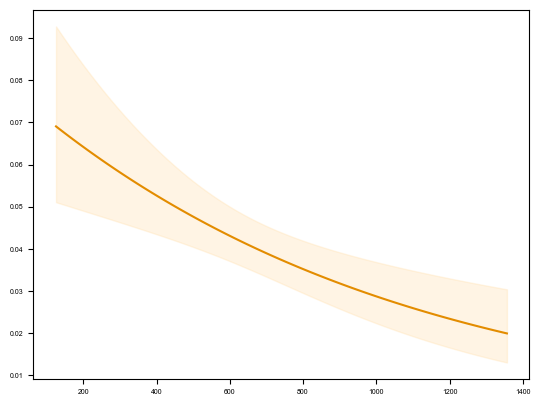

In [70]:
new_data = pd.DataFrame({
    'AP_position': ap_grid
})

pred = model.get_prediction(new_data, transform=True)  # depends on your library
pred_df = pred.summary_frame(alpha=0.05)

# Plot one line & fill
plt.plot(ap_grid, pred_df['predicted'], '-', color=fit_color)
plt.fill_between(ap_grid, pred_df['ci_lower'], pred_df['ci_upper'], 
                color=ci_color, alpha=0.3)
plt.show()

In [22]:
new_data

,AP_position
0,125.646651
1,138.080242
2,150.513832
3,162.947423
4,175.381013
...,...
95,1306.837747
96,1319.271338
97,1331.704928
98,1344.138519


In [ ]:
new_data

Now for fig S4, lets compare conditional probability given targeting AP position in vis cortex

In [42]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [73]:
#take AP position of cubelets containing visual cortex (and also specifically V1)
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
AP_position_dict = {}
AP_cond_prob_dict = {}
for mouse in mice:
    new_dict = {}
    cond_prob_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=pathlib.Path(parameters['lcm_directory']),
        area_threshold=0.5) #must contain at least 50% visual cortex
    V1_containing = areas_only_grouped[areas_only_grouped['VISp']>0].index.to_list()
    lcm_directory = pathlib.Path(parameters['lcm_directory'])
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    for sample in V1_containing:
        if sample in barcodes.columns:
            centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
            filtered_bc = barcodes[barcodes[sample]>0]
            if len(filtered_bc)<5:
                continue
            new_dict[sample] = centroid[0]-min_y
            filtered_bc.drop(columns=[sample], inplace=True)
            filtered_with_area = fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = filtered_bc, cortical=True, shuffled=False, IT_only=True)
            cond_prob_dict[sample] = filtered_with_area.astype(bool).mean(axis=0)
    AP_position_dict[mouse] = new_dict
    AP_cond_prob_dict[mouse] = cond_prob_dict
#for each mouse, given that a cubelet is in a particular AP position, what are the probablity of targeting other areas?

In [52]:
visual_areas = ['VISa', 'VISal', 'VISam', 'VISpm', 'VISp', 'VISpor', 'VISrl', 'VISl', 'VISli', 'VISpl']

In [81]:
area_dic= {}
for area in visual_areas:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'conditional_prob'])
    # ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        for sample in AP_position_dict[mouse].keys():
            AP_pos = AP_position_dict[mouse][sample]
            cond_prob = AP_cond_prob_dict[mouse][sample][area]
            new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP_pos], "conditional_prob": [cond_prob]})
            area_df = pd.concat([area_df, new_row], ignore_index=True)
    area_dic[area] = area_df

In [84]:
import statsmodels.formula.api as smf
area_p_values = pd.DataFrame(columns=['p_value', 'p_val_adj'])
area_results = {}
for area in visual_areas:
    df_long = area_dic[area]
    model = smf.mixedlm(
        formula="conditional_prob ~ AP_position",
        data=df_long,
        groups=df_long["mouse"],  # random intercept only
        re_formula="1"            # or omit if you want the default random intercept
    )

    res = model.fit()
    area_results[area]=res

    # Extract the p-value for the slope of AP_position
    p_value_ap = res.pvalues["AP_position"]
    area_p_values.loc[area, 'p_value'] = p_value_ap
    area_p_values.loc[area, 'p_val_adj'] = p_value_ap*len(visual_areas)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


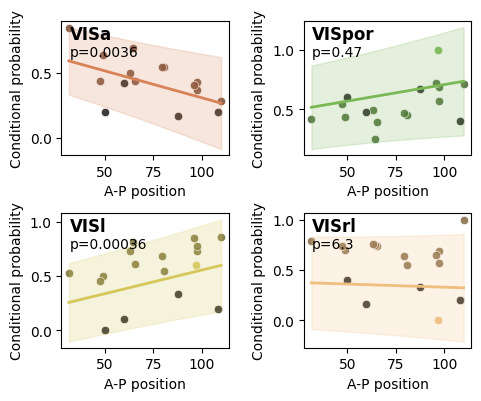

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
convert_dict = {
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISl": "LM"
}
HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISl', 'VISrl']
HVA_only = [s for s in visual_areas if s != 'VISp']
fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=False, sharey=False)

for i, area in enumerate(HVA_only):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(), df_long["AP_position"].max(), 50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["conditional_prob_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["conditional_prob_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["conditional_prob_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="conditional_prob", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    ax.plot(
        pred_df["AP_position"], 
        pred_df["conditional_prob_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        convert_dict[area], 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, fontweight='bold', color='black'
    )

    ax.set_xlabel("A-P position")
    ax.set_ylabel(f"P({convert_dict[area]}|V1 A-P)")

plt.tight_layout()
plt.show()


How about madial lateral positioning?

In [ ]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex


#select anterior and posterior parts of A1
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
VIS_mask_ipsi = VIS_mask*contra_mask
indices_VIS = np.argwhere(VIS_mask_ipsi == 1)
max_x = np.max(indices_VIS[:, 2])
min_x = np.min(indices_VIS[:, 2])
ML_midpoint_VIS = ((max_x - min_x) / 2) + min_x

# AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
# x_midpoint = VIS_mask.shape[2] // 2
# contra_mask = np.zeros_like(VIS_mask, dtype=bool)
# contra_mask[:, :, x_midpoint:] = 1
#take AP position of cubelets containing visual cortex (and also specifically V1)
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
ML_position_dict = {}
ML_cond_prob_dict = {}
for mouse in mice:
    new_dict = {}
    cond_prob_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=pathlib.Path(parameters['lcm_directory']),
        area_threshold=0.5) #must contain at least 30% visual cortex
    V1_containing = areas_only_grouped[areas_only_grouped['VISp']>0].index.to_list()
    lcm_directory = pathlib.Path(parameters['lcm_directory'])
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    for sample in V1_containing:
        if sample in barcodes.columns:
            centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
            filtered_bc = barcodes[barcodes[sample]>0]
            if len(filtered_bc)<5:
                continue
            new_dict[sample] = centroid[2]-min_x
            filtered_bc.drop(columns=[sample], inplace=True)
            filtered_with_area = fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = filtered_bc, cortical=True, shuffled=False, IT_only=True)
            cond_prob_dict[sample] = filtered_with_area.astype(bool).mean(axis=0)
    ML_position_dict[mouse] = new_dict
    ML_cond_prob_dict[mouse] = cond_prob_dict
#for each mouse, given that a cubelet is in a particular AP position, what are the probablity of targeting other areas?

In [75]:
import statsmodels.formula.api as smf
area_dic= {}
for area in visual_areas:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'conditional_prob'])
    # ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        for sample in ML_position_dict[mouse].keys():
            AP_pos = ML_position_dict[mouse][sample]
            cond_prob = ML_cond_prob_dict[mouse][sample][area]
            new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP_pos], "conditional_prob": [cond_prob]})
            area_df = pd.concat([area_df, new_row], ignore_index=True)
    area_dic[area] = area_df
area_p_values = pd.DataFrame(columns=['p_value', 'p_val_adj'])
area_results = {}
for area in visual_areas:
    df_long = area_dic[area]
    model = smf.mixedlm(
        formula="conditional_prob ~ AP_position",
        data=df_long,
        groups=df_long["mouse"],  # random intercept only
        re_formula="1"            # or omit if you want the default random intercept
    )

    res = model.fit()
    area_results[area]=res

    # Extract the p-value for the slope of AP_position
    p_value_ap = res.pvalues["AP_position"]
    area_p_values.loc[area, 'p_value'] = p_value_ap
    area_p_values.loc[area, 'p_val_adj'] = p_value_ap*len(visual_areas)

dict_keys([4, 16, 50, 78])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}
HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISl', 'VISrl']
HVA_only = [s for s in visual_areas if s != 'VISp']
fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=False, sharey=False)

for i, area in enumerate(HVA_only):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(), df_long["AP_position"].max(), 50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["conditional_prob_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["conditional_prob_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["conditional_prob_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="conditional_prob", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    ax.plot(
        pred_df["AP_position"], 
        pred_df["conditional_prob_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        convert_dict[area], 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, fontweight='bold', color='black'
    )

    ax.set_xlabel("M-L position")
    ax.set_ylabel(f"P({convert_dict[area]}|V1 M-L)")

plt.tight_layout()
plt.show()

